## extract tooth strcuture data from coco keypoint dataset and format it into yolo

In [3]:
import json
import os

def convert_bbox_to_yolo(bbox, image_width, image_height):
    x1, y1, w, h = bbox
    center_x = (2 * x1 + w) / (2 * image_width)
    center_y = (2 * y1 + h) / (2 * image_height)
    normalized_width = w / image_width
    normalized_height = h / image_height
    return [center_x, center_y, normalized_width, normalized_height]

def normalize_keypoints(keypoints, image_width, image_height):
    normalized_keypoints = []
    for i in range(0, len(keypoints), 3):
        x = keypoints[i] / image_width
        y = keypoints[i + 1] / image_height
        z = keypoints[i + 2]
        normalized_keypoints.extend([x, y, z])
    return normalized_keypoints

def write_annotations_to_txt(annotations, image_file_name, output_dir, image_dimensions):
    image_width, image_height = image_dimensions
    txt_file_name = os.path.join(output_dir, image_file_name.replace('.png', '.txt').replace('.jpg', '.txt'))
    with open(txt_file_name, 'w') as txt_file:
        for annotation in annotations:
            category_id = annotation['category_id']
            # Mapping category ids as per requirements
            if category_id == 1:
                category_id = 0
            elif category_id == 4:
                category_id = 1
            bbox = annotation['bbox']
            keypoints = annotation['keypoints']
            
            # Convert bbox to YOLO format and normalize
            bbox_yolo = convert_bbox_to_yolo(bbox, image_width, image_height)
            
            # Normalize keypoints
            normalized_keypoints = normalize_keypoints(keypoints, image_width, image_height)
            
            bbox_str = ' '.join(map(str, bbox_yolo))
            keypoints_str = ' '.join(map(str, normalized_keypoints))
            
            txt_file.write(f"{category_id} {bbox_str} {keypoints_str}\n")

def convert_dataset_to_txt(dataset_path, output_dir):
    with open(dataset_path, 'r') as f:
        data = json.load(f)
    
    images = data['images']
    annotations = data['annotations']
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    for image in images:
        image_id = image['id']
        image_file_name = image['file_name']
        image_width = image['width']
        image_height = image['height']
        image_dimensions = (image_width, image_height)
        
        image_annotations = [annotation for annotation in annotations if annotation['image_id'] == image_id]
        
        if image_annotations:
            write_annotations_to_txt(image_annotations, image_file_name, output_dir, image_dimensions)

if __name__ == "__main__":
    dataset_path =r"C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\landmark data\skeleton\annotations\person_keypoints_default.json"  # Change this to the path of your dataset JSON file
    output_dir =r"C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\landmark data\skeleton\labels"  # Change this to the desired output directory
    convert_dataset_to_txt(dataset_path, output_dir)

## extract bounding boxes and change labels

In [4]:
import json
import os

# Load the COCO annotation file
annotation_file =r'C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\annotations\instances_default.json'

# Define the categories you want to extract (7, 8, and 9 in your case)
target_category_ids = [7,8,9]

# Read the annotation data
with open(annotation_file, 'r') as f:
    coco_data = json.load(f)

# Create a dictionary to store annotations per image
image_annotations = {}

# Iterate through annotations and group them by image_id
for annotation in coco_data['annotations']:
    if annotation['category_id'] in target_category_ids:
        image_id = annotation['image_id']
        if image_id not in image_annotations:
            image_annotations[image_id] = []
        image_annotations[image_id].append(annotation)

# Directory to save the text files
output_dir = r'C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\labels'

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Iterate through images and save the annotations in text files
for image in coco_data['images']:
    image_id = image['id']
    image_filename = image['file_name']
    txt_filename = os.path.splitext(image_filename)[0] + '.txt'

    if image_id in image_annotations:
        annotations_to_write = []
        for annotation in image_annotations[image_id]:
            category_id = annotation['category_id']
            if category_id==7:
                category_id=0
            else:
                category_id=1
            bbox = annotation['bbox']
            annotations_to_write.append(f"{category_id} {' '.join(map(str, bbox))}")

        with open(os.path.join(output_dir, txt_filename), 'w') as txt_file:
            txt_file.write('\n'.join(annotations_to_write))

## convert bounding boxes ot yolo format

In [19]:
# Define the coco_to_yolo function
def coco_to_yolo(x1, y1, w, h, image_w, image_h):
    center_x = (2 * x1 + w) / (2 * image_w)
    center_y = (2 * y1 + h) / (2 * image_h)
    normalized_width = w / image_w
    normalized_height = h / image_h
    return [center_x, center_y, normalized_width, normalized_height]

# Directory containing the text files
txt_dir = r'C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\Untitled Folder\common_structure\temp\labels'

# Iterate through the text files
for txt_file in os.listdir(txt_dir):
    if txt_file.endswith('.txt'):
        with open(os.path.join(txt_dir, txt_file), 'r') as f:
            lines = f.readlines()

        # Process each line and update the numbers
        updated_lines = []
        for line in lines:
            parts = line.strip().split(' ')
            if len(parts) >= 5:  # Ensure at least 5 elements (class_id, x1, y1, w, h)
                class_id = parts[0]
                x1, y1, w, h = map(float, parts[1:])
                image_w, image_h = 1024, 1024  # Your image dimensions

                # Apply the coco_to_yolo function
                yolo_values = coco_to_yolo(x1, y1, w, h, image_w, image_h)

                # Convert the yolo values back to strings
                yolo_values = [str(value) for value in yolo_values]

                # Update the line with the yolo values
                updated_line = ' '.join([class_id] + yolo_values)
                updated_lines.append(updated_line)

        # Write the updated lines back to the same text file
        with open(os.path.join(txt_dir, txt_file), 'w') as f:
            f.write('\n'.join(updated_lines))

## modified above code to cater to variable image sizes

In [5]:
import os
from PIL import Image

# Define the coco_to_yolo function
def coco_to_yolo(x1, y1, w, h, image_w, image_h):
    center_x = (2 * x1 + w) / (2 * image_w)
    center_y = (2 * y1 + h) / (2 * image_h)
    normalized_width = w / image_w
    normalized_height = h / image_h
    return [center_x, center_y, normalized_width, normalized_height]

# Directory containing the text files and images
txt_dir = r'C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\labels'
img_dir =r'C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images'

# Iterate through the text files
for txt_file in os.listdir(txt_dir):
    if txt_file.endswith('.txt'):
        # Get the corresponding image filename prefix
        img_filename_prefix = os.path.splitext(txt_file)[0]

        # Search for corresponding image file with the same prefix
        img_file = None
        for filename in os.listdir(img_dir):
            if filename.startswith(img_filename_prefix):
                img_file = os.path.join(img_dir, filename)
                break

        if img_file is None:
            print(f"No corresponding image found for {txt_file}")
            continue

        print(f"Processing {txt_file} with corresponding image {img_file}")

        # Get image dimensions
        with Image.open(img_file) as img:
            image_w, image_h = img.size

        with open(os.path.join(txt_dir, txt_file), 'r') as f:
            lines = f.readlines()

        # Process each line and update the numbers
        updated_lines = []
        for line in lines:
            parts = line.strip().split(' ')
            if len(parts) >= 5:  # Ensure at least 5 elements (class_id, x1, y1, w, h)
                class_id = parts[0]
                x1, y1, w, h = map(float, parts[1:])

                # Apply the coco_to_yolo function
                yolo_values = coco_to_yolo(x1, y1, w, h, image_w, image_h)

                # Convert the yolo values back to strings
                yolo_values = [str(value) for value in yolo_values]

                # Update the line with the yolo values
                updated_line = ' '.join([class_id] + yolo_values)
                updated_lines.append(updated_line)

        # Write the updated lines back to the same text file
        with open(os.path.join(txt_dir, txt_file), 'w') as f:
            f.write('\n'.join(updated_lines))

Processing 000051_jpg_20231102132058531.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\000051_jpg_20231102132058531.jpg
Processing 000117_jpg_20231215122447992.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\000117_jpg_20231215122447992.jpg
Processing 000138_jpg_202312151224484.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\000138_jpg_202312151224484.jpg
Processing 000154_jpg_20231102132058567.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\000154_jpg_20231102132058567.jpg
Processing 000231_jpg_20231102132058559.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPa

Processing 012008_jpg_2023121512244814.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\012008_jpg_2023121512244814.jpg
Processing 012082_jpg_20231102132058518.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\012082_jpg_20231102132058518.jpg
Processing 012139_jpg_20231102132058540.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\012139_jpg_20231102132058540.jpg
Processing 012204_jpg_20231102132058529.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\012204_jpg_20231102132058529.jpg
Processing 012264_jpg_20231215122447992.txt with corresponding image C:\Users\HP\Desktop\dental\Dental

Processing 014928_jpg_20231102132058535.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\014928_jpg_20231102132058535.jpg
Processing 014999_jpg_20231102132058529.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\014999_jpg_20231102132058529.jpg
Processing 015044_jpg_2023121512244823.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\015044_jpg_2023121512244823.jpg
Processing 015096_jpg_202312151224488.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\015096_jpg_202312151224488.jpg
Processing 015097_jpg_20231102132058532.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPano

Processing 017567_jpg_20231102132058527.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\017567_jpg_20231102132058527.jpg
Processing 017596_jpg_20231102132058532.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\017596_jpg_20231102132058532.jpg
Processing 017711_jpg_2023121512244818.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\017711_jpg_2023121512244818.jpg
Processing 017739_jpg_202312151224472.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\017739_jpg_202312151224472.jpg
Processing 017937_jpg_20231102132058540.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPano

Processing 067351_jpg_2023121512244813.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\067351_jpg_2023121512244813.jpg
Processing 1._jpg_20231005184521369.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\1._jpg_20231005184521369.jpg
Processing 10._jpg_20231005184521419.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\10._jpg_20231005184521419.jpg
Processing 100._jpg_20231005184521781.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\100._jpg_20231005184521781.jpg
Processing 101._jpg_20231005184521782.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landm

Processing 140_jpg_20231005184519848.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\140_jpg_20231005184519848.jpg
Processing 141_jpg_20231005184519857.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\141_jpg_20231005184519857.jpg
Processing 142_jpg_20231005184519858.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\142_jpg_20231005184519858.jpg
Processing 143_jpg_20231005184519859.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\143_jpg_20231005184519859.jpg
Processing 144_jpg_20231005184519869.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_d

Processing 182_jpg_2023100518452047.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\182_jpg_2023100518452047.jpg
Processing 183_jpg_2023100518452048.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\183_jpg_2023100518452048.jpg
Processing 184_jpg_2023100518452050.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\184_jpg_2023100518452050.jpg
Processing 185_jpg_2023100518452051.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\185_jpg_2023100518452051.jpg
Processing 186_jpg_2023100518452053.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\

Processing 223_jpg_20231005184520176.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\223_jpg_20231005184520176.jpg
Processing 224_jpg_20231005184520177.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\224_jpg_20231005184520177.jpg
Processing 225_jpg_20231005184520179.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\225_jpg_20231005184520179.jpg
Processing 226_jpg_20231005184520180.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\226_jpg_20231005184520180.jpg
Processing 227_jpg_20231005184520190.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_d

Processing 267_jpg_20231005184521943.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\267_jpg_20231005184521943.jpg
Processing 268_jpg_20231005184521943.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\268_jpg_20231005184521943.jpg
Processing 269_jpg_20231005184521944.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\269_jpg_20231005184521944.jpg
Processing 27._jpg_20231005184521485.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\27._jpg_20231005184521485.jpg
Processing 270_jpg_20231005184521944.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_d

Processing 308_jpg_202310051845225.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\308_jpg_202310051845225.jpg
Processing 309_jpg_202310051845226.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\309_jpg_202310051845226.jpg
Processing 31._jpg_20231005184521504.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\31._jpg_20231005184521504.jpg
Processing 310_jpg_202310051845228.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\310_jpg_202310051845228.jpg
Processing 32._jpg_20231005184521506.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\pre

Processing 367w_jpg_20231005184522111.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\367w_jpg_20231005184522111.jpg
Processing 368w_jpg_20231005184522113.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\368w_jpg_20231005184522113.jpg
Processing 369w_jpg_20231005184522116.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\369w_jpg_20231005184522116.jpg
Processing 37._jpg_20231005184521536.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\37._jpg_20231005184521536.jpg
Processing 370w_jpg_20231005184522118.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\lan

Processing 408w_jpg_20231005184522201.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\408w_jpg_20231005184522201.jpg
Processing 409w_jpg_20231005184522202.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\409w_jpg_20231005184522202.jpg
Processing 41._jpg_20231005184521542.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\41._jpg_20231005184521542.jpg
Processing 410w_jpg_20231005184522203.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\410w_jpg_20231005184522203.jpg
Processing 411w_jpg_20231005184522215.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\lan

Processing 454w_jpg_20231005184522282.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\454w_jpg_20231005184522282.jpg
Processing 455w_jpg_20231005184522283.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\455w_jpg_20231005184522283.jpg
Processing 456w_jpg_20231005184522319.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\456w_jpg_20231005184522319.jpg
Processing 457w_jpg_20231005184522321.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\457w_jpg_20231005184522321.jpg
Processing 458w_jpg_20231005184522322.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\l

Processing 546w_jpg_20231005184520415.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\546w_jpg_20231005184520415.jpg
Processing 547w_jpg_20231005184520417.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\547w_jpg_20231005184520417.jpg
Processing 548w_png_20231005184520419.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\548w_png_20231005184520419.png
Processing 549w_jpg_20231005184520423.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\549w_jpg_20231005184520423.jpg
Processing 55._jpg_20231005184521589.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\la

Processing 592w_jpg_20231005184520565.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\592w_jpg_20231005184520565.jpg
Processing 593w_jpg_20231005184520567.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\593w_jpg_20231005184520567.jpg
Processing 594w_jpg_20231005184520583.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\594w_jpg_20231005184520583.jpg
Processing 595w_jpg_20231005184520584.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\595w_jpg_20231005184520584.jpg
Processing 596w_jpg_20231005184520586.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\l

Processing 632w_jpg_20231005184520711.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\632w_jpg_20231005184520711.jpg
Processing 633w_jpg_20231005184520712.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\633w_jpg_20231005184520712.jpg
Processing 634w_jpg_20231005184520727.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\634w_jpg_20231005184520727.jpg
Processing 635w_jpg_20231005184520728.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\635w_jpg_20231005184520728.jpg
Processing 636w_jpg_20231005184520729.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\l

Processing 685w_jpg_20231005184520911.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\685w_jpg_20231005184520911.jpg
Processing 69._jpg_20231005184521628.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\69._jpg_20231005184521628.jpg
Processing 691w_jpg_20231005184520915.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\691w_jpg_20231005184520915.jpg
Processing 696w_jpg_20231005184520929.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\696w_jpg_20231005184520929.jpg
Processing 697w_jpg_20231005184520933.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\lan

Processing 748w_jpg_2023100518452179.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\748w_jpg_2023100518452179.jpg
Processing 749w_jpg_2023100518452180.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\749w_jpg_2023100518452180.jpg
Processing 75._jpg_20231005184521675.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\75._jpg_20231005184521675.jpg
Processing 750w_jpg_2023100518452181.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\750w_jpg_2023100518452181.jpg
Processing 751w_jpg_2023100518452182.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_d

Processing 785w_jpg_20231005184521266.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\785w_jpg_20231005184521266.jpg
Processing 786w_jpg_20231005184521269.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\786w_jpg_20231005184521269.jpg
Processing 787w_jpg_20231005184521270.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\787w_jpg_20231005184521270.jpg
Processing 788w_jpg_20231005184521285.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images\788w_jpg_20231005184521285.jpg
Processing 789w_jpg_20231005184521286.txt with corresponding image C:\Users\HP\Desktop\dental\DentalPanoramicXrays\l

## find common image files in datasets

In [6]:
import os
import shutil

# Define the directories
directory_A = r"C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\landmark data\skeleton\images"
directory_B = r"C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\images"
directory_C = r"C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\images"

# Create directory C if it doesn't exist
if not os.path.exists(directory_C):
    os.makedirs(directory_C)

# Get a list of files in directory A
files_A = os.listdir(directory_A)

# Get a list of files in directory B
files_B = os.listdir(directory_B)

# Loop through the files in directory A
for file_A in files_A:
    # Check if the file exists in directory B
    if file_A in files_B:
        # Construct the full path of the file in directory A
        src_path_A = os.path.join(directory_A, file_A)
        
        # Construct the full path of the destination in directory C
        dest_path_C = os.path.join(directory_C, file_A)
        
        # Move the file from directory A to directory C
        shutil.copy(src_path_A, dest_path_C)
        print(f"Moved {file_A} from directory A to directory C")
        
        # Construct the full path of the file in directory B
        src_path_B = os.path.join(directory_B, file_A)
        
        ## you arent supposed to delete them
        # Delete the file from directory B
        #os.remove(src_path_B)
        #print(f"Deleted {file_A} from directory B")

# Optional: Delete the files from directory A after the loop if needed
# for file_A in files_A:
#     src_path_A = os.path.join(directory_A, file_A)
#     os.remove(src_path_A)
#     print(f"Deleted {file_A} from directory A")

Moved 000051_jpg_20231102132058531.jpg from directory A to directory C
Moved 000117_jpg_20231215122447992.jpg from directory A to directory C
Moved 000138_jpg_202312151224484.jpg from directory A to directory C
Moved 000154_jpg_20231102132058567.jpg from directory A to directory C
Moved 000231_jpg_20231102132058559.jpg from directory A to directory C
Moved 000271_jpg_202312151224472.jpg from directory A to directory C
Moved 009311_jpg_20231102132058529.jpg from directory A to directory C
Moved 009379_jpg_20231102132058548.jpg from directory A to directory C
Moved 009394_jpg_2023121512244812.jpg from directory A to directory C
Moved 009403_jpg_20231102132058557.jpg from directory A to directory C
Moved 009404_jpg_20231102132058543.jpg from directory A to directory C
Moved 009516_jpg_20231102132058561.jpg from directory A to directory C
Moved 009620_jpg_2023121512244811.jpg from directory A to directory C
Moved 009659_jpg_2023121512244819.jpg from directory A to directory C
Moved 009877_

Moved 017937_jpg_20231102132058540.jpg from directory A to directory C
Moved 017950_jpg_202312151224486.jpg from directory A to directory C
Moved 017975_jpg_20231102132058531.jpg from directory A to directory C
Moved 018014_jpg_20231102132058550.jpg from directory A to directory C
Moved 018228_jpg_202312151224485.jpg from directory A to directory C
Moved 018483_jpg_2023121512244817.jpg from directory A to directory C
Moved 019440_jpg_20231215122447997.jpg from directory A to directory C
Moved 019468_jpg_20231215122447999.jpg from directory A to directory C
Moved 019751_jpg_2023121512244820.jpg from directory A to directory C
Moved 019850_jpg_202312151224485.jpg from directory A to directory C
Moved 019956_jpg_20231215122447991.jpg from directory A to directory C
Moved 020164_jpg_2023121512244810.jpg from directory A to directory C
Moved 020882_jpg_20231215122447995.jpg from directory A to directory C
Moved 021068_jpg_20231215122447992.jpg from directory A to directory C
Moved 021533_jp

Moved 18._jpg_20231005184521453.jpg from directory A to directory C
Moved 180_jpg_2023100518452045.jpg from directory A to directory C
Moved 181_jpg_20231005184520167.jpg from directory A to directory C
Moved 182_jpg_2023100518452047.jpg from directory A to directory C
Moved 183_jpg_2023100518452048.jpg from directory A to directory C
Moved 184_jpg_2023100518452050.jpg from directory A to directory C
Moved 185_jpg_2023100518452051.jpg from directory A to directory C
Moved 186_jpg_2023100518452053.jpg from directory A to directory C
Moved 187_jpg_2023100518452054.jpg from directory A to directory C
Moved 188_jpg_2023100518452057.jpg from directory A to directory C
Moved 189_jpg_2023100518452065.jpg from directory A to directory C
Moved 19._jpg_20231005184521454.jpg from directory A to directory C
Moved 190_jpg_2023100518452066.jpg from directory A to directory C
Moved 191_jpg_2023100518452071.jpg from directory A to directory C
Moved 192_jpg_2023100518452079.jpg from directory A to dire

Moved 297_jpg_20231005184521988.jpg from directory A to directory C
Moved 298_jpg_20231005184521989.jpg from directory A to directory C
Moved 299_jpg_20231005184521991.jpg from directory A to directory C
Moved 3._jpg_20231005184521410.jpg from directory A to directory C
Moved 30._jpg_20231005184521503.jpg from directory A to directory C
Moved 300_jpg_20231005184521992.jpg from directory A to directory C
Moved 301_jpg_20231005184521994.jpg from directory A to directory C
Moved 302_jpg_20231005184521995.jpg from directory A to directory C
Moved 303_jpg_202310051845211.jpg from directory A to directory C
Moved 304_jpg_202310051845211.jpg from directory A to directory C
Moved 305_jpg_202310051845222.jpg from directory A to directory C
Moved 306_jpg_202310051845223.jpg from directory A to directory C
Moved 307_jpg_202310051845224.jpg from directory A to directory C
Moved 308_jpg_202310051845225.jpg from directory A to directory C
Moved 309_jpg_202310051845226.jpg from directory A to directo

Moved 413w_jpg_20231005184522217.jpg from directory A to directory C
Moved 414w_jpg_20231005184522220.jpg from directory A to directory C
Moved 415w_jpg_20231005184522222.jpg from directory A to directory C
Moved 416w_jpg_20231005184522223.jpg from directory A to directory C
Moved 417w_jpg_20231005184522224.jpg from directory A to directory C
Moved 418w_jpg_20231005184522226.jpg from directory A to directory C
Moved 419w_jpg_20231005184522227.jpg from directory A to directory C
Moved 42._jpg_20231005184521543.jpg from directory A to directory C
Moved 420w_jpg_20231005184522228.jpg from directory A to directory C
Moved 421w_jpg_20231005184522229.jpg from directory A to directory C
Moved 422w_jpg_20231005184522230.jpg from directory A to directory C
Moved 423w_jpg_20231005184522233.jpg from directory A to directory C
Moved 424w_jpg_20231005184522235.jpg from directory A to directory C
Moved 425w_jpg_20231005184522237.jpg from directory A to directory C
Moved 426w_jpg_20231005184522238.jp

Moved 577w_jpg_20231005184520523.jpg from directory A to directory C
Moved 579w_jpg_20231005184520525.jpg from directory A to directory C
Moved 58._jpg_20231005184521598.jpg from directory A to directory C
Moved 580w_jpg_20231005184520526.jpg from directory A to directory C
Moved 581w_jpg_20231005184520526.jpg from directory A to directory C
Moved 582w_jpg_20231005184520528.jpg from directory A to directory C
Moved 583w_jpg_20231005184520529.jpg from directory A to directory C
Moved 584w_jpg_20231005184520530.jpg from directory A to directory C
Moved 585w_jpg_20231005184520531.jpg from directory A to directory C
Moved 586w_jpg_20231005184520533.jpg from directory A to directory C
Moved 587w_jpg_20231005184520534.jpg from directory A to directory C
Moved 588w_jpg_20231005184520536.jpg from directory A to directory C
Moved 589w_jpg_20231005184520537.jpg from directory A to directory C
Moved 59._jpg_20231005184521599.jpg from directory A to directory C
Moved 590w_jpg_20231005184520551.jpg

Moved 726w_jpg_20231005184520993.jpg from directory A to directory C
Moved 727w_jpg_2023100518452126.jpg from directory A to directory C
Moved 728w_jpg_2023100518452127.jpg from directory A to directory C
Moved 729w_jpg_2023100518452131.jpg from directory A to directory C
Moved 73._jpg_20231005184521662.jpg from directory A to directory C
Moved 730w_jpg_2023100518452132.jpg from directory A to directory C
Moved 731w_jpg_2023100518452133.jpg from directory A to directory C
Moved 732w_jpg_2023100518452134.jpg from directory A to directory C
Moved 733w_jpg_2023100518452136.jpg from directory A to directory C
Moved 734w_jpg_2023100518452137.jpg from directory A to directory C
Moved 735w_jpg_2023100518452138.jpg from directory A to directory C
Moved 736w_jpg_2023100518452140.jpg from directory A to directory C
Moved 737w_jpg_2023100518452154.jpg from directory A to directory C
Moved 738w_jpg_2023100518452155.jpg from directory A to directory C
Moved 739w_jpg_2023100518452156.jpg from direct

## find common landmark label files from datasets


In [7]:
import os
import shutil

# Define the directories
directory_A = r"C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\landmark data\skeleton\labels"
directory_B = r"C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\labels"
directory_C = r"C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\skeleton"

# Create directory C if it doesn't exist
if not os.path.exists(directory_C):
    os.makedirs(directory_C)

# Get a list of files in directory A
files_A = os.listdir(directory_A)

# Get a list of files in directory B
files_B = os.listdir(directory_B)

# Loop through the files in directory A
for file_A in files_A:
    # Check if the file exists in directory B
    if file_A in files_B:
        # Construct the full path of the file in directory A
        src_path_A = os.path.join(directory_A, file_A)
        
        # Construct the full path of the destination in directory C
        dest_path_C = os.path.join(directory_C, file_A)
        
        # Move the file from directory A to directory C
        shutil.copy(src_path_A, dest_path_C)
        print(f"copied {file_A} from directory A to directory C")
        
        # Construct the full path of the file in directory B
        src_path_B = os.path.join(directory_B, file_A)
        
        # Delete the file from directory B
        #os.remove(src_path_B)
        #print(f"Deleted {file_A} from directory B")

# Optional: Delete the files from directory A after the loop if needed
# for file_A in files_A:
#     src_path_A = os.path.join(directory_A, file_A)
#     os.remove(src_path_A)
#     print(f"Deleted {file_A} from directory A")

copied 000051_jpg_20231102132058531.txt from directory A to directory C
copied 000117_jpg_20231215122447992.txt from directory A to directory C
copied 000138_jpg_202312151224484.txt from directory A to directory C
copied 000154_jpg_20231102132058567.txt from directory A to directory C
copied 000231_jpg_20231102132058559.txt from directory A to directory C
copied 000271_jpg_202312151224472.txt from directory A to directory C
copied 009311_jpg_20231102132058529.txt from directory A to directory C
copied 009379_jpg_20231102132058548.txt from directory A to directory C
copied 009394_jpg_2023121512244812.txt from directory A to directory C
copied 009403_jpg_20231102132058557.txt from directory A to directory C
copied 009404_jpg_20231102132058543.txt from directory A to directory C
copied 009516_jpg_20231102132058561.txt from directory A to directory C
copied 009620_jpg_2023121512244811.txt from directory A to directory C
copied 009659_jpg_2023121512244819.txt from directory A to directory C

copied 016738_jpg_20231215122447998.txt from directory A to directory C
copied 016768_jpg_20231102132058557.txt from directory A to directory C
copied 016779_jpg_202312151224488.txt from directory A to directory C
copied 016829_jpg_20231102132058544.txt from directory A to directory C
copied 016855_jpg_20231102132058526.txt from directory A to directory C
copied 016856_jpg_20231102132058558.txt from directory A to directory C
copied 016969_jpg_20231102132058550.txt from directory A to directory C
copied 016970_jpg_20231102132058551.txt from directory A to directory C
copied 017056_jpg_20231102132058522.txt from directory A to directory C
copied 017057_jpg_20231102132058565.txt from directory A to directory C
copied 017058_jpg_20231102132058563.txt from directory A to directory C
copied 017112_jpg_20231102132058555.txt from directory A to directory C
copied 017138_jpg_20231102132058525.txt from directory A to directory C
copied 017192_jpg_20231102132058571.txt from directory A to direct

copied 174_jpg_2023100518452014.txt from directory A to directory C
copied 175_jpg_2023100518452037.txt from directory A to directory C
copied 176_jpg_2023100518452038.txt from directory A to directory C
copied 177_jpg_2023100518452039.txt from directory A to directory C
copied 178_jpg_2023100518452041.txt from directory A to directory C
copied 179_jpg_2023100518452044.txt from directory A to directory C
copied 18._jpg_20231005184521453.txt from directory A to directory C
copied 180_jpg_2023100518452045.txt from directory A to directory C
copied 181_jpg_20231005184520167.txt from directory A to directory C
copied 182_jpg_2023100518452047.txt from directory A to directory C
copied 183_jpg_2023100518452048.txt from directory A to directory C
copied 184_jpg_2023100518452050.txt from directory A to directory C
copied 185_jpg_2023100518452051.txt from directory A to directory C
copied 186_jpg_2023100518452053.txt from directory A to directory C
copied 187_jpg_2023100518452054.txt from direc

copied 334_jpg_2023100518452248.txt from directory A to directory C
copied 335_jpg_2023100518452252.txt from directory A to directory C
copied 336_jpg_2023100518452254.txt from directory A to directory C
copied 337_jpg_2023100518452257.txt from directory A to directory C
copied 339_jpg_2023100518452259.txt from directory A to directory C
copied 34._jpg_20231005184521508.txt from directory A to directory C
copied 340_jpg_2023100518452261.txt from directory A to directory C
copied 341w_jpg_20231005184521367.txt from directory A to directory C
copied 342w_jpg_20231005184521368.txt from directory A to directory C
copied 343w_jpg_2023100518452266.txt from directory A to directory C
copied 344w_jpg_2023100518452267.txt from directory A to directory C
copied 345w_jpg_2023100518452269.txt from directory A to directory C
copied 346w_jpg_2023100518452271.txt from directory A to directory C
copied 347w_jpg_2023100518452272.txt from directory A to directory C
copied 348w_jpg_2023100518452274.txt f

copied 446w_jpg_20231005184522272.txt from directory A to directory C
copied 447w_jpg_20231005184522273.txt from directory A to directory C
copied 448w_jpg_20231005184522275.txt from directory A to directory C
copied 449w_jpg_20231005184522276.txt from directory A to directory C
copied 45._jpg_20231005184521556.txt from directory A to directory C
copied 450w_jpg_20231005184522277.txt from directory A to directory C
copied 451w_jpg_20231005184522280.txt from directory A to directory C
copied 452w_jpg_20231005184522281.txt from directory A to directory C
copied 453w_jpg_20231005184522282.txt from directory A to directory C
copied 454w_jpg_20231005184522282.txt from directory A to directory C
copied 455w_jpg_20231005184522283.txt from directory A to directory C
copied 456w_jpg_20231005184522319.txt from directory A to directory C
copied 457w_jpg_20231005184522321.txt from directory A to directory C
copied 458w_jpg_20231005184522322.txt from directory A to directory C
copied 459w_jpg_20231

copied 638w_jpg_20231005184520730.txt from directory A to directory C
copied 639w_jpg_20231005184520731.txt from directory A to directory C
copied 64._jpg_20231005184521619.txt from directory A to directory C
copied 640w_jpg_20231005184520731.txt from directory A to directory C
copied 641w_jpg_20231005184520742.txt from directory A to directory C
copied 642w_jpg_20231005184520743.txt from directory A to directory C
copied 643w_jpg_20231005184520760.txt from directory A to directory C
copied 644w_jpg_20231005184520766.txt from directory A to directory C
copied 645w_jpg_20231005184520767.txt from directory A to directory C
copied 646w_jpg_20231005184520768.txt from directory A to directory C
copied 647w_jpg_20231005184520795.txt from directory A to directory C
copied 648w_jpg_20231005184520795.txt from directory A to directory C
copied 649w_jpg_20231005184520816.txt from directory A to directory C
copied 65._jpg_20231005184521620.txt from directory A to directory C
copied 650w_jpg_202310

copied 80._jpg_20231005184521686.txt from directory A to directory C
copied 81._jpg_20231005184521703.txt from directory A to directory C
copied 82._jpg_20231005184521704.txt from directory A to directory C
copied 83._jpg_20231005184521713.txt from directory A to directory C
copied 84._jpg_20231005184521713.txt from directory A to directory C
copied 85._jpg_20231005184521722.txt from directory A to directory C
copied 86._jpg_20231005184521737.txt from directory A to directory C
copied 87._jpg_20231005184521738.txt from directory A to directory C
copied 88._jpg_20231005184521739.txt from directory A to directory C
copied 89._jpg_20231005184521744.txt from directory A to directory C
copied 9._jpg_20231005184521835.txt from directory A to directory C
copied 90._jpg_20231005184521745.txt from directory A to directory C
copied 91._jpg_20231005184521752.txt from directory A to directory C
copied 92._jpg_20231005184521753.txt from directory A to directory C
copied 93._jpg_20231005184521756.tx

## find common structure label files from dataset

In [8]:
import os
import shutil

# Define the directories
directory_B = r"C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\landmark data\skeleton\labels"
directory_A = r"C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\teeth-structure\structure\labels"
directory_C = r"C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\structure"

# Create directory C if it doesn't exist
if not os.path.exists(directory_C):
    os.makedirs(directory_C)

# Get a list of files in directory A
files_A = os.listdir(directory_A)

# Get a list of files in directory B
files_B = os.listdir(directory_B)

# Loop through the files in directory A
for file_A in files_A:
    # Check if the file exists in directory B
    if file_A in files_B:
        # Construct the full path of the file in directory A
        src_path_A = os.path.join(directory_A, file_A)
        
        # Construct the full path of the destination in directory C
        dest_path_C = os.path.join(directory_C, file_A)
        
        # Move the file from directory A to directory C
        shutil.copy(src_path_A, dest_path_C)
        print(f"Moved {file_A} from directory A to directory C")
        
        # Construct the full path of the file in directory B
        src_path_B = os.path.join(directory_B, file_A)
        
        # Delete the file from directory B
        #os.remove(src_path_B)
        #print(f"Deleted {file_A} from directory B")

# Optional: Delete the files from directory A after the loop if needed
# for file_A in files_A:
#     src_path_A = os.path.join(directory_A, file_A)
#     os.remove(src_path_A)
#     print(f"Deleted {file_A} from directory A")

Moved 000051_jpg_20231102132058531.txt from directory A to directory C
Moved 000117_jpg_20231215122447992.txt from directory A to directory C
Moved 000138_jpg_202312151224484.txt from directory A to directory C
Moved 000154_jpg_20231102132058567.txt from directory A to directory C
Moved 000231_jpg_20231102132058559.txt from directory A to directory C
Moved 000271_jpg_202312151224472.txt from directory A to directory C
Moved 009311_jpg_20231102132058529.txt from directory A to directory C
Moved 009379_jpg_20231102132058548.txt from directory A to directory C
Moved 009394_jpg_2023121512244812.txt from directory A to directory C
Moved 009403_jpg_20231102132058557.txt from directory A to directory C
Moved 009404_jpg_20231102132058543.txt from directory A to directory C
Moved 009516_jpg_20231102132058561.txt from directory A to directory C
Moved 009620_jpg_2023121512244811.txt from directory A to directory C
Moved 009659_jpg_2023121512244819.txt from directory A to directory C
Moved 009877_

Moved 017347_jpg_20231102132058542.txt from directory A to directory C
Moved 017517_jpg_20231102132058537.txt from directory A to directory C
Moved 017567_jpg_20231102132058527.txt from directory A to directory C
Moved 017596_jpg_20231102132058532.txt from directory A to directory C
Moved 017711_jpg_2023121512244818.txt from directory A to directory C
Moved 017739_jpg_202312151224472.txt from directory A to directory C
Moved 017937_jpg_20231102132058540.txt from directory A to directory C
Moved 017950_jpg_202312151224486.txt from directory A to directory C
Moved 017975_jpg_20231102132058531.txt from directory A to directory C
Moved 018014_jpg_20231102132058550.txt from directory A to directory C
Moved 018228_jpg_202312151224485.txt from directory A to directory C
Moved 018483_jpg_2023121512244817.txt from directory A to directory C
Moved 019440_jpg_20231215122447997.txt from directory A to directory C
Moved 019468_jpg_20231215122447999.txt from directory A to directory C
Moved 019751_j

Moved 17._jpg_20231005184521452.txt from directory A to directory C
Moved 170_jpg_20231005184519991.txt from directory A to directory C
Moved 171_jpg_20231005184519992.txt from directory A to directory C
Moved 172_jpg_20231005184519997.txt from directory A to directory C
Moved 173_jpg_20231005184519998.txt from directory A to directory C
Moved 174_jpg_2023100518452014.txt from directory A to directory C
Moved 175_jpg_2023100518452037.txt from directory A to directory C
Moved 176_jpg_2023100518452038.txt from directory A to directory C
Moved 177_jpg_2023100518452039.txt from directory A to directory C
Moved 178_jpg_2023100518452041.txt from directory A to directory C
Moved 179_jpg_2023100518452044.txt from directory A to directory C
Moved 18._jpg_20231005184521453.txt from directory A to directory C
Moved 180_jpg_2023100518452045.txt from directory A to directory C
Moved 181_jpg_20231005184520167.txt from directory A to directory C
Moved 182_jpg_2023100518452047.txt from directory A to 

Moved 308_jpg_202310051845225.txt from directory A to directory C
Moved 309_jpg_202310051845226.txt from directory A to directory C
Moved 31._jpg_20231005184521504.txt from directory A to directory C
Moved 310_jpg_202310051845228.txt from directory A to directory C
Moved 32._jpg_20231005184521506.txt from directory A to directory C
Moved 324w_jpg_20231005184521367.txt from directory A to directory C
Moved 33._jpg_20231005184521507.txt from directory A to directory C
Moved 332_jpg_2023100518452245.txt from directory A to directory C
Moved 333_jpg_2023100518452247.txt from directory A to directory C
Moved 334_jpg_2023100518452248.txt from directory A to directory C
Moved 335_jpg_2023100518452252.txt from directory A to directory C
Moved 336_jpg_2023100518452254.txt from directory A to directory C
Moved 337_jpg_2023100518452257.txt from directory A to directory C
Moved 339_jpg_2023100518452259.txt from directory A to directory C
Moved 34._jpg_20231005184521508.txt from directory A to dire

Moved 472w_jpg_20231005184522350.txt from directory A to directory C
Moved 473w_jpg_20231005184522351.txt from directory A to directory C
Moved 474w_jpg_20231005184522353.txt from directory A to directory C
Moved 475w_jpg_20231005184522354.txt from directory A to directory C
Moved 476w_jpg_20231005184522358.txt from directory A to directory C
Moved 477w_jpg_20231005184522359.txt from directory A to directory C
Moved 478w_jpg_20231005184522361.txt from directory A to directory C
Moved 479w_jpg_20231005184522362.txt from directory A to directory C
Moved 48._jpg_20231005184521567.txt from directory A to directory C
Moved 480w_jpg_20231005184522364.txt from directory A to directory C
Moved 481w_jpg_20231005184522366.txt from directory A to directory C
Moved 482w_jpg_20231005184522368.txt from directory A to directory C
Moved 483w_jpg_20231005184522371.txt from directory A to directory C
Moved 484w_jpg_20231005184522374.txt from directory A to directory C
Moved 485w_jpg_20231005184522375.tx

Moved 673w_jpg_20231005184520877.txt from directory A to directory C
Moved 674w_jpg_20231005184520878.txt from directory A to directory C
Moved 676w_jpg_20231005184520902.txt from directory A to directory C
Moved 68._jpg_20231005184521628.txt from directory A to directory C
Moved 684w_jpg_20231005184520903.txt from directory A to directory C
Moved 685w_jpg_20231005184520911.txt from directory A to directory C
Moved 69._jpg_20231005184521628.txt from directory A to directory C
Moved 691w_jpg_20231005184520915.txt from directory A to directory C
Moved 696w_jpg_20231005184520929.txt from directory A to directory C
Moved 697w_jpg_20231005184520933.txt from directory A to directory C
Moved 7._jpg_20231005184521415.txt from directory A to directory C
Moved 70._jpg_20231005184521629.txt from directory A to directory C
Moved 700w_jpg_20231005184520951.txt from directory A to directory C
Moved 707w_jpg_20231005184520972.txt from directory A to directory C
Moved 708w_jpg_20231005184520975.txt fr

## assign bounding boxes

In [9]:
import os
import math

# Function to calculate L1 distance between two points (x1, y1) and (x2, y2)
def l1_distance(x1, y1, x2, y2):
    return abs(x1 - x2) + abs(y1 - y2)

def euclidean_distance(x1, y1, x2, y2):
    return math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

# Function to read bounding boxes from a text file and group them by class
def read_bounding_boxes(filename):
    class_bboxes = {}
    with open(filename, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) >= 5:
                class_id = int(parts[0])
                bbox_info = list(map(float, parts[1:5]))
                landmarks = list(map(float, parts[5:])) if len(parts) > 5 else []
                if class_id not in class_bboxes:
                    class_bboxes[class_id] = []
                class_bboxes[class_id].append((bbox_info, landmarks))
    return class_bboxes

# Function to find the closest bounding box in source to the target bounding box using L1 distance
def find_closest_bbox(target_bbox, source_bboxes, used_target_bboxes):
    min_distance = float('inf')
    closest_bbox = None
    closest_landmarks = None
    for source_bbox, landmarks in source_bboxes:
        x1, y1, w1, h1 = target_bbox
        x2, y2, w2, h2 = source_bbox
        center_distance = l1_distance(x1 + w1 / 2, y1 + h1 / 2, x2 + w2 / 2, y2 + h2 / 2)
        source_bbox_tuple = tuple(source_bbox)  # Convert source_bbox to a tuple
        if center_distance < min_distance and source_bbox_tuple not in used_target_bboxes:
            min_distance = center_distance
            closest_bbox = source_bbox
            closest_landmarks = landmarks
    return closest_bbox, closest_landmarks

# Source and target directories
source_directory = r'C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\structure'
target_directory = r'C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\skeleton'
output_directory = r'C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed'

# Loop through files in the source directory
for source_filename in os.listdir(source_directory):
    if source_filename.endswith(".txt"):  # Process only .txt files
        source_file_path = os.path.join(source_directory, source_filename)
        target_file_path = os.path.join(target_directory, source_filename)
        output_file_path = os.path.join(output_directory, source_filename)

        # Read bounding boxes from both files and group by class
        source_bboxes = read_bounding_boxes(source_file_path)
        target_bboxes = read_bounding_boxes(target_file_path)

        # Keep track of used target bounding boxes
        used_target_bboxes = set()

        # Replace bounding boxes in source with closest matches from target with priority
        replaced_bboxes = []

        for class_id, source_class_bboxes in source_bboxes.items():
            if class_id in target_bboxes:
                target_class_bboxes = target_bboxes[class_id]
                while source_class_bboxes:  # Continue until all source bounding boxes are matched
                    min_distance = float('inf')
                    best_match_index = None
                    for source_index, (source_bbox, source_landmarks) in enumerate(source_class_bboxes):
                        closest_bbox, closest_landmarks = find_closest_bbox(source_bbox, target_class_bboxes, used_target_bboxes)
                        if closest_bbox:
                            center_distance = l1_distance(source_bbox[0] + source_bbox[2] / 2, source_bbox[1] + source_bbox[3] / 2,
                                                          closest_bbox[0] + closest_bbox[2] / 2, closest_bbox[1] + closest_bbox[3] / 2)
                            if center_distance < min_distance:
                                min_distance = center_distance
                                best_match_index = source_index
                                best_match_bbox = closest_bbox
                                best_match_landmarks = closest_landmarks
                    if best_match_index is not None:
                        # Include landmarks from the closest target bounding box
                        source_landmarks = best_match_landmarks
                        # Mark the target bounding box as used
                        used_target_bboxes.add(tuple(best_match_bbox))
                        # Append the source class bounding box with either the target landmarks or source landmarks
                        replaced_bboxes.append([class_id] + source_class_bboxes[best_match_index][0] + source_landmarks)
                        # Remove the matched source bounding box from the list
                        source_class_bboxes.pop(best_match_index)
                    else:
                        # No more matches found for this class, exit the loop
                        break

        # Write the updated bounding boxes to the output file
        with open(output_file_path, 'w') as file:
            for bbox_info in replaced_bboxes:
                class_id = bbox_info[0]
                bbox_coords = bbox_info[1:5]
                landmarks = bbox_info[5:]
                file.write(f"{class_id} {' '.join(map(str, bbox_coords))} {' '.join(map(str, landmarks))}\n")

        print(f"Bounding boxes replaced and saved in {output_file_path}")


Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\000051_jpg_20231102132058531.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\000117_jpg_20231215122447992.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\000138_jpg_202312151224484.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\000154_jpg_20231102132058567.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\000231_jpg_20231102132058559.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\000271_jpg_2023

Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\012915_jpg_20231102132058518.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\013204_jpg_20231102132058548.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\013289_jpg_202312151224486.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\013290_jpg_20231102132058547.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\013348_jpg_20231102132058547.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\013349_jpg_2023

Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\016855_jpg_20231102132058526.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\016856_jpg_20231102132058558.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\016969_jpg_20231102132058550.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\016970_jpg_20231102132058551.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\017056_jpg_20231102132058522.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\017057_jpg_20

Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\046496_jpg_20231215122447994.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\055443_jpg_2023121512244819.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\056725_jpg_202312151224484.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\056882_jpg_202312151224488.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\061874_jpg_2023121512244816.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\063902_jpg_20231215

Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\139_jpg_20231005184519847.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\14._jpg_20231005184521429.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\140_jpg_20231005184519848.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\141_jpg_20231005184519857.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\142_jpg_20231005184519858.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\143_jpg_20231005184519859.tx

Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\185_jpg_2023100518452051.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\186_jpg_2023100518452053.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\187_jpg_2023100518452054.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\188_jpg_2023100518452057.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\189_jpg_2023100518452065.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\19._jpg_20231005184521454.txt
Bou

Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\254_jpg_20231005184521885.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\255_jpg_20231005184521886.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\256_jpg_20231005184521911.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\257_jpg_20231005184521911.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\258_jpg_20231005184521934.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\259_jpg_20231005184521935.tx

Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\301_jpg_20231005184521994.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\302_jpg_20231005184521995.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\303_jpg_202310051845211.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\304_jpg_202310051845211.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\305_jpg_202310051845222.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\306_jpg_202310051845223.txt
Boundi

Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\385w_jpg_20231005184522149.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\386w_jpg_20231005184522151.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\387w_jpg_20231005184522152.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\388w_jpg_20231005184522154.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\389w_jpg_20231005184522156.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\39._jpg_202310051845215

Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\43._jpg_20231005184521554.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\430w_jpg_20231005184522243.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\431w_jpg_20231005184522246.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\432w_jpg_20231005184522248.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\433w_jpg_20231005184522250.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\434w_jpg_202310051845222

Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\479w_jpg_20231005184522362.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\48._jpg_20231005184521567.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\480w_jpg_20231005184522364.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\481w_jpg_20231005184522366.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\482w_jpg_20231005184522368.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\483w_jpg_202310051845223

Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\577w_jpg_20231005184520523.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\579w_jpg_20231005184520525.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\58._jpg_20231005184521598.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\580w_jpg_20231005184520526.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\581w_jpg_20231005184520526.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\583w_jpg_202310051845205

Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\627w_jpg_20231005184520705.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\628w_jpg_20231005184520707.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\629w_jpg_20231005184520708.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\63._jpg_20231005184521616.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\630w_jpg_20231005184520709.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\631w_jpg_202310051845207

Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\684w_jpg_20231005184520903.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\685w_jpg_20231005184520911.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\69._jpg_20231005184521628.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\691w_jpg_20231005184520915.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\696w_jpg_20231005184520929.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\697w_jpg_202310051845209

Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\745w_jpg_2023100518452173.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\746w_jpg_2023100518452174.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\747w_jpg_2023100518452177.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\748w_jpg_2023100518452179.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\749w_jpg_2023100518452180.txt
Bounding boxes replaced and saved in C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed\75._jpg_20231005184521675.tx

In [10]:
import os

def process_files_in_directory(directory):
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            filepath = os.path.join(directory, filename)
            process_file(filepath)

def process_file(filepath):
    with open(filepath, 'r') as file:
        lines = file.readlines()

    with open(filepath, 'w') as file:
        for line in lines:
            # Replace 2.0 with 2 and 1.0 with 1
            line = line.replace('2.0', '2').replace('1.0', '1')
            file.write(line)

# Example usage
directory =r"C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed"
process_files_in_directory(directory)

## take the union of bounding boxes if below a threshold otherwise same as before

In [11]:



import os

def parse_annotation_line(line):
    parts = line.strip().split()
    class_id = parts[0]
    bbox = list(map(float, parts[1:5]))
    landmarks = " ".join(parts[5:])
    return class_id, bbox, landmarks

def parse_directory(directory):
    annotations = {}
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            with open(os.path.join(directory, filename), "r") as file:
                lines = file.readlines()
                annotations[filename] = [parse_annotation_line(line) for line in lines]
    return annotations

def calculate_union_bbox(bbox_A, bbox_B):
    x1 = min(bbox_A[0] - bbox_A[2]/2, bbox_B[0] - bbox_B[2]/2)
    y1 = min(bbox_A[1] - bbox_A[3]/2, bbox_B[1] - bbox_B[3]/2)
    x2 = max(bbox_A[0] + bbox_A[2]/2, bbox_B[0] + bbox_B[2]/2)
    y2 = max(bbox_A[1] + bbox_A[3]/2, bbox_B[1] + bbox_B[3]/2)
    width = x2 - x1
    height = y2 - y1
    return [x1 + width/2, y1 + height/2, width, height]

def write_union_annotations(annotations_A, annotations_B, output_directory):
    for filename, annotations_list_A in annotations_A.items():
        annotations_list_B = annotations_B.get(filename, [])
        print(f"Processing file: {filename}")
        with open(os.path.join(output_directory, filename), "w") as output_file:
            for annotation_A in annotations_list_A:
                for annotation_B in annotations_list_B:
                    if annotation_A[0] == annotation_B[0] and annotation_A[2] == annotation_B[2]:
                        class_id = annotation_A[0]
                        bbox_A = annotation_A[1]
                        bbox_B = annotation_B[1]
                        union_bbox = calculate_union_bbox(bbox_A, bbox_B)
                        landmarks = annotation_A[2]
                        output_line = f"{class_id} {' '.join(map(str, union_bbox))} {landmarks}\n"
                        print("Union annotation:", output_line)
                        output_file.write(output_line)
                        break  # Exit the loop after finding a matching annotation pair

directory_A =r"C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\preprocessed"
directory_B =r"C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\skeleton"
output_directory =r"C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized"


annotations_A = parse_directory(directory_A)
annotations_B = parse_directory(directory_B)

write_union_annotations(annotations_A, annotations_B, output_directory)

Processing file: 000051_jpg_20231102132058531.txt
Union annotation: 0 0.68311875 0.045012500000000004 0.03161250000000004 0.08985833333333333 0.67436875 0.07781666666666666 2 0.69700625 0.05075833333333333 2

Union annotation: 0 0.133978125 0.0268125 0.09691875000000003 0.05345833333333333 0.08551875 0.023808333333333334 2 0.17678750000000001 0.006616666666666667 1

Union annotation: 0 0.6924656250000001 0.8979291666666667 0.21429375000000006 0.20414166666666655 0.58531875 0.8190083333333333 2 0.6431874999999999 0.7958583333333333 2

Union annotation: 0 0.524321875 0.8074958333333333 0.94926875 0.3850083333333334 0.95168125 0.6809083333333333 2 0.99895625 0.6149916666666667 1

Processing file: 000117_jpg_20231215122447992.txt
Union annotation: 1 0.7774437499999999 0.5287666666666666 0.34482499999999994 0.28096666666666664 0.6455500000000001 0.6666666666666666 2 0.9400687499999999 0.65525 2

Union annotation: 1 0.40635 0.625 0.35853749999999995 0.32183333333333325 0.2791125 0.773975 2 0

Union annotation: 0 0.302734375 0.9467578125 0.0390625 0.10453124999999996 0.285234375 0.92501953125 2 0.32083984375 0.8944921875 2

Union annotation: 0 0.8377880859375 0.0419921875 0.30643554687499996 0.080078125 0.69375 0.009833984375 2 0.991005859375 0.070830078125 2

Union annotation: 0 0.1435546875 0.93359375 0.02734375 0.12890625 0.133466796875 0.872451171875 2 0.146181640625 0.87583984375 2

Union annotation: 0 0.950830078125 0.83935546875 0.09638671875000004 0.3193359375 0.90263671875 0.76755859375 2 0.996396484375 0.68111328125 2

Union annotation: 0 0.64453125 0.90126953125 0.099609375 0.19160156250000004 0.598935546875 0.8080078125 2 0.627763671875 0.80546875 2

Union annotation: 1 0.243193359375 0.128251953125 0.18755859375 0.23568359375 0.22416015625 0.01041015625 2 0.33697265625 0.070478515625 2

Processing file: 280_jpg_20231005184521961.txt
Union annotation: 0 0.7052685546875 0.11688964843750001 0.04120117187500005 0.229482421875 0.69697265625 0.2304296875 2 0.719648437

Union annotation: 1 0.6661328125 0.680078125 0.34591796875 0.329609375 0.561884765625 0.8448828125 2 0.8374609375 0.688115234375 2

Union annotation: 1 0.09002929687500001 0.725830078125 0.17685546875000002 0.25724609375000007 0.004619140625 0.854453125 2 0.169638671875 0.7933984375 2

Union annotation: 1 0.32931152343750003 0.7422070312500001 0.31731445312500006 0.2691992187500001 0.1889453125 0.836630859375 2 0.484326171875 0.808583984375 2

Union annotation: 1 0.6755615234375 0.11907226562499999 0.30452148437499993 0.23408203125 0.552470703125 0.014521484375 1 0.818154296875 0.0095703125 2

Union annotation: 0 0.551376953125 0.9176513671875 0.12677734374999994 0.16469726562499998 0.491611328125 0.880224609375 2 0.576005859375 0.876005859375 2

Union annotation: 0 0.19052734375 0.924287109375 0.03886718750000001 0.15142578124999984 0.173046875 0.8530078125 2 0.19203125 0.84857421875 2

Union annotation: 0 0.923583984375 0.722294921875 0.15283203125 0.5198632812500001 0.84716796875 0.

## instead of fixing landmarks, increase bounding boxes

In [17]:
import os
import numpy as np

# Set the value of x and y
x = 0.4
y = 0.4

# Input and output directories
input_directory =r'C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\data filtering\preprocessed_data\labels'  # Replace with the path to the input directory
output_directory =r'C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\data filtering\preprocessed+big_box'  # Replace with the path to the output directory

# Create the output directory if it doesn't exist
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Function to process the files
def process_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    modified_lines = []
    for line in lines:
        values = line.strip().split()
        if len(values) >= 5:
            values[3] = str(float(values[3]) + x)
            values[4] = str(float(values[4]) + y)
        modified_lines.append(' '.join(values) + '\n')

    output_file_path = os.path.join(output_directory, os.path.basename(file_path))
    with open(output_file_path, 'w') as file:
        file.writelines(modified_lines)

# Process each file in the input directory
for filename in os.listdir(input_directory):
    if filename.endswith(".txt"):
        file_path = os.path.join(input_directory, filename)
        process_file(file_path)
        


## fix landmarks

In [ ]:
import json
import os
# Input directory and output directory paths
input_directory = r'C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\data filtering\test\unionized'
output_directory = r'C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\data filtering\test\unionized+landmarks_moved'

# Define the number of pixels to move landmarks towards the X center
move_pixels = 0
counter=0
file_list=[]
# Loop through files in the input directory
for filename in os.listdir(input_directory):
    if filename.endswith(".txt"):  # Process only .txt files
        input_file_path = os.path.join(input_directory, filename)
        output_file_path = os.path.join(output_directory, filename)

        # Read input lines from the input file
        with open(input_file_path, 'r') as input_file:
            input_lines = input_file.readlines()

        # Define changes to the output file path
        output_data = []

        # Process each input line
        for input_line in input_lines:
            input_values = input_line.strip().split()
            if len(input_values) >= 10:
                class_id = int(input_values[0])
                bbox_info = list(map(float, input_values[1:5]))
                x_center, y_center, width, height = bbox_info
                landmarks = list(map(float, input_values[5:11]))
                occl_1 = landmarks[2]
                occl_2 = landmarks[5]

                del landmarks[2]
                del landmarks[4]
                x_max = x_center + width / 2
                x_min = x_center - width / 2
                y_max = y_center + height / 2
                y_min = y_center - height / 2

                updated_landmarks = []
                for i in range(0, len(landmarks), 2):
                    landmark_x, landmark_y = landmarks[i], landmarks[i + 1]

                    if (landmark_x >= x_min and landmark_x <= x_max and
                            landmark_y >= y_min and landmark_y <= y_max):
                        pass

                    if landmark_x < x_min:
                        landmark_x = x_min
                        counter=counter+1
                        file_list.append(filename)

                    if landmark_x > x_max:
                        landmark_x = x_max
                        counter=counter+1
                        file_list.append(filename)

                    if landmark_y < y_min:
                        landmark_y = y_min
                        counter=counter+1
                        file_list.append(filename)

                    if landmark_y > y_max:
                        landmark_y = y_max
                        counter=counter+1
                        file_list.append(filename)

                    arr = [landmark_x, landmark_y]
                    updated_landmarks.extend(arr)

                updated_landmarks.insert(2, occl_1)
                updated_landmarks.insert(5, occl_2)
                output_data.append(f"{class_id} {x_center} {y_center} {width} {height} {' '.join(map(str, updated_landmarks))}\n")

        # Write the valid data with updated landmarks (without occlusion parameters) to the output text file
        with open(output_file_path, 'w') as output_file:
            output_file.writelines(output_data)
print(counter)
file_list=list(set(file_list))
print(len(file_list))

In [19]:
file_list

['662w_jpg_20231005184520832.txt',
 '623w_jpg_20231005184520697.txt',
 '14._jpg_20231005184521429.txt',
 '88._jpg_20231005184521739.txt',
 '170_jpg_20231005184519991.txt',
 '106._jpg_20231005184521810.txt',
 '712w_jpg_20231005184520979.txt',
 '594w_jpg_20231005184520583.txt',
 '673w_jpg_20231005184520877.txt',
 '696w_jpg_20231005184520929.txt',
 '131_jpg_20231005184519806.txt',
 '150_jpg_20231005184519906.txt',
 '568w_jpg_20231005184520515.txt',
 '730w_jpg_2023100518452132.txt',
 '18._jpg_20231005184521453.txt',
 '37._jpg_20231005184521536.txt',
 '562w_jpg_20231005184520504.txt',
 '149_jpg_20231005184519900.txt',
 '571w_jpg_20231005184520519.txt',
 '613w_jpg_20231005184520661.txt',
 '611w_jpg_20231005184520659.txt',
 '638w_jpg_20231005184520730.txt',
 '74._jpg_20231005184521664.txt',
 '548w_png_20231005184520419.txt',
 '718w_jpg_20231005184520987.txt',
 '732w_jpg_2023100518452134.txt',
 '666w_jpg_20231005184520853.txt',
 '620w_jpg_20231005184520681.txt',
 '58._jpg_20231005184521598.txt

In [ ]:
#notes: increasing  boxes by 5% decreases number of images with landmarks outside bounding box from 360 to 225
#notes increasing  boxes by 10% decreases number of images with landmarks outside bounding box from 360 to 174
#notes increasing  boxes by 20% decreases number of images with landmarks outside bounding box from 360 to 121
#notes increasing  boxes by 40% decreases number of images with landmarks outside bounding box from 360 to 87

## visualization

In [13]:
import os
import cv2
import numpy as np

# Function to read bounding box data from a text file
def read_bbox_data(file_path):
    with open(file_path, 'r') as file:
        bbox_data_lines = file.readlines()

    bbox_data = []
    for line in bbox_data_lines:
        parts = line.strip().split()
        class_id = int(parts[0])
        x_center_norm, y_center_norm, width_norm, height_norm = map(float, parts[1:5])
        landmarks_norm = list(map(float, parts[5:11]))  # Extract x, y, and z coordinates

        bbox_data.append([class_id, x_center_norm, y_center_norm, width_norm, height_norm, *landmarks_norm])

    return bbox_data


# Function to visualize bounding boxes and landmarks for an image
def visualize_image(image_path, bbox_data, output_dir):
    # Load the image
    image = cv2.imread(image_path)

    # Image size (assuming 1024x1024)
    #img_width, img_height = 1024, 1024
    img_height, img_width = image.shape[:2]

    # Generate unique colors for bounding boxes
    bbox_colors = np.random.randint(0, 255, size=(len(bbox_data), 3), dtype=np.uint8)

    for i, bbox_info in enumerate(bbox_data):
        class_id = int(bbox_info[0])
        x_center_norm, y_center_norm, width_norm, height_norm = bbox_info[1:5]
        landmarks_norm = bbox_info[5:]

        # Convert YOLO normalized coordinates to image coordinates
        x_center = int(x_center_norm * img_width)
        y_center = int(y_center_norm * img_height)
        width = int(width_norm * img_width)
        height = int(height_norm * img_height)

        # Calculate bounding box coordinates
        x1 = int(x_center - width / 2)
        y1 = int(y_center - height / 2)
        x2 = int(x_center + width / 2)
        y2 = int(y_center + height / 2)

        # Get the unique color for this bounding box
        color = tuple(map(int, bbox_colors[i]))

        # Draw bounding box rectangle
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)

        # Draw landmarks if available
        if len(landmarks_norm) >= 3:
            for j in range(0, len(landmarks_norm), 3):
                landmark_x_norm, landmark_y_norm, landmark_z = landmarks_norm[j:j+3]
                landmark_x = int(landmark_x_norm * img_width)
                landmark_y = int(landmark_y_norm * img_height)
                if landmark_z == 2:
                    landmark_color = (0, 0, 255)  # Red color for z=2
                    #landmark_color=color
                else:
                    landmark_color = (255, 0, 0)  # Blue color for other z-values
                    #landmark_color=color
                print(landmark_x)
                print(landmark_y)
                cv2.circle(image, (landmark_x, landmark_y), 5, landmark_color, -1)

    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Save the image with bounding boxes and landmarks
    image_name = os.path.basename(image_path)
    output_image_path = os.path.join(output_dir, image_name)
    cv2.imwrite(output_image_path, image)
# Directory paths
image_dir = r'C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\images'
bbox_data_dir = r"C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized"
output_dir = r'C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\visuals'  # Output directory for saving annotated images

# Iterate over each image file in the directory
for image_file in os.listdir(image_dir):
    if image_file.endswith('.jpg') or image_file.endswith('.png'):
        image_path = os.path.join(image_dir, image_file)
        bbox_data_file = os.path.join(bbox_data_dir, os.path.splitext(image_file)[0] + '.txt')

        if os.path.exists(bbox_data_file):
            bbox_data = read_bbox_data(bbox_data_file)
            print(bbox_data_file)
            visualize_image(image_path, bbox_data, output_dir)


C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\000051_jpg_20231102132058531.txt
1078
93
1115
60
136
28
282
7
936
982
1029
955
1522
817
1598
737
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\000117_jpg_20231215122447992.txt
1032
800
1504
786
446
928
936
821
19
978
364
901
21
178
120
153
194
120
561
112
131
129
189
107
1194
46
1592
60
564
63
652
22
391
980
435
979
958
936
1027
870
1528
763
1595
731
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\000138_jpg_202312151224484.txt
1008
1073
1432
1065
447
1080
907
1064
68
1068
408
1041
1038
312
1443
298
282
246
498
238
583
279
989
268
21
210
178
208
512
222
572
233
1415
228
1587
189
972
228
1030
252
191
187
273
195
1450
1031
1592
996
909
1077
975
1069
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\000154_jpg_20231102132058567.txt
1002
97
1080
82
1

25
995
265
919
327
947
765
821
279
973
318
968
1281
585
1472
285
801
843
873
815
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\011389_jpg_20231102132058539.txt
734
87
804
66
250
72
336
68
183
868
265
878
701
883
785
884
1227
828
1595
805
770
827
1212
783
23
876
187
843
278
851
709
864
27
218
245
100
804
64
1183
55
328
99
734
107
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\011494_jpg_20231102132058539.txt
1526
946
1585
700
1175
993
1433
1006
78
856
488
988
1073
229
1309
195
164
67
534
142
588
206
984
215
988
150
1070
136
1284
90
1402
158
14
98
165
98
530
136
604
153
1082
1058
1165
1035
1430
1046
1518
999
528
939
608
956
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\011565_jpg_20231102132058569.txt
465
68
531
81
416
896
496
871
51
891
161
901
1459
836
1541
782
945
885
1022
901
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_de

1003
70
1581
141
1496
750
1592
696
122
915
224
885
449
882
572
849
970
846
1022
835
205
802
445
818
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\013653_jpg_202312151224487.txt
35
166
234
151
808
243
1047
178
1138
220
1350
199
722
149
792
187
1069
203
1130
201
1362
174
1416
170
240
137
278
128
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\013686_jpg_202312151224483.txt
195
223
240
257
1514
282
1538
275
684
316
712
311
616
1106
711
1067
1243
1092
1289
1106
60
1024
147
1049
1175
286
1195
287
1295
1100
1567
1078
720
1040
1197
1056
150
990
616
1075
1558
330
1586
226
30
245
180
210
1203
357
1499
294
712
352
1180
346
243
297
676
278
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\013689_jpg_202312151224487.txt
1383
1035
1564
1032
1035
1063
1295
1060
35
1032
460
1095
564
1087
983
1084
945
389
1164
350
1274
364
1511
281
484
410
857
391
30
369
40

C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\015175_jpg_202312151224471.txt
1043
274
1079
264
1342
278
1359
272
574
234
605
234
725
1076
831
1072
1321
1074
1385
1061
1391
983
1572
975
852
1048
1331
1034
1386
339
1569
219
1087
333
1345
327
178
205
572
257
610
301
1046
312
293
936
742
1023
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\015395_jpg_20231102132058562.txt
302
73
409
54
615
98
694
98
275
1058
508
1030
1366
882
1597
803
908
959
985
940
71
929
283
930
959
875
1348
797
391
142
614
172
16
123
283
96
690
148
1096
136
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\015428_jpg_20231102132058564.txt
409
87
469
87
107
64
155
60
497
915
574
910
149
904
201
882
1073
921
1183
912
15
710
154
839
26
273
94
100
205
879
496
881
951
71
1380
68
135
114
411
149
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final

C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\017346_jpg_202312151224473.txt
1265
334
1523
312
449
930
846
1081
572
345
1046
249
1506
213
1586
233
1046
202
1238
186
1387
1151
1436
1148
827
1147
965
1132
16
227
542
258
18
616
433
973
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\017347_jpg_20231102132058542.txt
158
890
392
791
16
853
48
805
222
92
436
97
480
106
875
170
896
8
1300
26
143
29
218
38
853
85
875
72
443
68
482
58
463
1022
696
1050
1419
544
1587
410
83
914
177
943
883
975
1025
808
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\017517_jpg_20231102132058537.txt
727
1024
1096
845
346
910
544
921
31
923
275
929
1224
880
1495
689
24
171
148
147
240
188
446
165
953
73
1276
63
521
121
883
117
887
80
951
90
446
96
510
86
148
76
234
92
1541
717
1588
686
560
1043
744
1066
280
1035
339
1018
1153
929
1253
929
C:\Users\HP\Desktop\dental\De

C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\037756_jpg_20231215122447999.txt
1513
259
1557
241
749
220
789
193
1207
259
1227
259
1492
1122
1562
1124
1121
1091
1212
1092
4
690
85
766
543
1017
653
1030
1569
1107
1599
1105
1219
1061
1491
1079
664
1014
1120
1059
82
809
458
1084
1565
301
1599
299
380
132
732
261
1232
293
1510
281
777
240
1195
279
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\041018_jpg_202312151224471.txt
587
42
637
37
160
108
182
108
408
1173
507
1149
959
1163
1041
1138
1337
1132
1398
1083
1403
1039
1597
1035
1047
1113
1337
1122
520
1129
945
1156
5
1020
414
1127
958
2
1237
4
2
131
151
110
649
39
898
2
199
62
579
42
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\041315_jpg_2023121512244810.txt
1300
117
1360
107
985
174
1026
162
151
147
219
127
641
140
720
159
1001
972
1082
955
482
944
543
970
1384
957
1453
940
1456
919
159

C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\105._jpg_20231005184521809.txt
362
46
420
4
768
34
1017
46
79
86
116
74
252
845
289
845
621
801
654
749
981
659
1015
633
654
674
972
669
280
784
600
695
23
893
238
753
439
26
743
7
2
136
65
120
135
106
359
96
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\106._jpg_20231005184521810.txt
666
64
981
25
224
820
278
820
46
806
84
794
848
610
1012
345
547
748
621
724
631
737
843
631
84
737
224
727
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\107._jpg_20231005184521811.txt
691
191
729
189
902
142
944
135
14
32
84
60
953
981
1023
977
379
942
426
970
717
972
780
970
42
877
383
856
432
910
720
924
785
919
951
917
958
211
1014
199
724
227
895
183
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\108_jpg_20231005184521836.txt
252
56
278
56
359
773
397
771


954
108
1022
131
131
88
172
111
642
61
709
55
321
87
398
75
429
959
487
953
10
978
241
881
772
901
1017
873
259
902
430
874
172
177
334
177
713
88
942
93
25
142
127
134
405
126
655
123
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\135_jpg_20231005184519820.txt
565
812
853
763
226
812
504
777
25
829
172
754
37
102
126
219
156
221
336
242
675
214
932
218
154
112
175
107
635
130
691
102
961
122
997
113
364
119
395
91
867
873
1018
772
196
876
233
886
518
879
577
874
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\136_jpg_20231005184519831.txt
752
804
995
628
163
925
313
888
21
967
100
900
397
925
668
815
30
254
100
240
605
149
815
21
312
228
559
138
128
230
285
227
289
156
306
170
558
113
598
113
102
168
128
178
114
955
161
967
327
941
392
932
682
854
755
850
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\137_jpg_20231005184519832.txt
201
154

280
171
310
177
338
876
390
890
126
893
144
893
694
864
752
864
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\165_jpg_20231005184519974.txt
629
123
640
123
293
82
334
119
65
116
135
112
941
820
1015
764
245
904
301
900
30
921
70
907
603
893
661
874
70
839
229
825
299
853
584
806
661
834
932
755
135
151
287
177
343
133
631
175
647
105
857
37
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\166_jpg_20231005184519975.txt
310
144
359
140
60
137
144
133
612
123
677
121
35
942
65
921
243
902
296
893
600
914
696
916
670
857
949
738
72
834
236
825
137
224
287
212
6
210
46
194
673
170
900
168
367
203
600
189
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\167_jpg_20231005184519977.txt
898
92
932
74
580
127
600
123
293
38
321
45
544
867
603
855
923
802
942
800
190
781
211
786
949
752
998
734
23
734
194
717
219
783
544
813
937
177
1007
119
114
137
275

119
753
440
741
848
727
993
673
502
801
794
801
23
734
86
682
729
240
977
296
32
184
172
217
262
285
408
288
205
123
285
107
434
161
752
154
794
921
864
869
441
845
512
866
98
825
116
822
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\195_jpg_2023100518452089.txt
336
930
586
850
659
841
921
778
123
932
261
888
13
946
44
914
210
259
359
250
713
198
923
70
430
229
675
196
11
252
126
247
357
175
434
165
670
142
706
140
149
191
215
161
63
979
102
965
270
940
325
944
598
904
652
879
926
790
1019
763
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\196_jpg_2023100518452095.txt
649
743
939
666
81
743
261
769
315
783
603
780
4
808
58
764
16
215
86
208
156
151
301
229
668
186
911
182
343
170
640
165
643
95
667
105
336
98
354
97
117
96
169
76
46
950
70
913
955
705
1015
685
257
908
313
894
598
859
675
838
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized

285
804
558
785
626
787
925
773
56
757
229
738
123
112
285
142
652
149
874
123
338
109
603
135
294
105
345
72
74
88
126
60
617
86
649
102
934
747
1022
657
221
805
271
809
559
832
601
793
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\219_jpg_20231005184520166.txt
142
114
191
98
152
812
198
807
352
809
423
806
724
794
797
771
785
745
1002
561
196
722
345
710
432
804
696
710
621
191
857
119
39
778
154
698
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\22._jpg_20231005184521472.txt
512
948
532
945
802
877
820
855
776
53
904
52
531
893
778
863
458
111
736
220
124
172
301
97
868
142
991
142
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\220_jpg_20231005184520172.txt
668
148
703
174
369
179
397
158
928
120
991
98
151
191
212
168
275
873
320
868
60
873
102
873
619
874
666
853
659
811
967
762
105
813
273
799
13
822
58
808
320
841
612
827
30
257
1

C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\244_jpg_20231005184521871.txt
51
182
436
853
717
832
738
815
451
801
720
757
741
771
1002
706
444
91
694
128
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\246_jpg_20231005184521877.txt
719
222
947
308
433
276
456
275
86
127
183
198
487
944
657
974
0
749
187
833
206
793
462
961
980
377
1022
352
188
220
419
223
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\247_jpg_20231005184521879.txt
99
26
142
37
874
161
884
161
606
155
638
155
300
165
329
166
744
941
826
920
1
178
95
198
889
138
999
121
135
190
286
147
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\248_jpg_20231005184521880.txt
960
89
986
85
425
114
472
53
707
824
1017
790
234
58
409
178
478
116
687
83
699
83
964
132
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preproc

787
65
822
66
493
115
520
113
145
54
257
99
531
856
606
845
890
820
925
808
220
764
253
800
259
777
535
815
0
713
222
721
609
794
880
788
525
172
788
102
838
117
980
72
275
162
487
136
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\278_jpg_20231005184521956.txt
952
863
1021
863
719
858
892
889
364
828
655
873
2
787
104
847
954
289
1020
291
743
231
911
214
147
166
364
163
918
199
932
195
644
944
706
925
377
151
702
142
888
942
932
939
120
839
349
872
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\279_jpg_20231005184521959.txt
481
87
504
88
783
121
822
138
933
934
997
906
712
870
755
882
309
813
393
806
401
796
707
851
768
858
933
918
4
676
306
801
221
16
470
120
832
177
1013
156
508
121
766
130
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\28._jpg_20231005184521487.txt
292
947
328
915
710
10
1014
72
136
893
149
896
924
785
1020
697
613
82

C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\306_jpg_202310051845223.txt
988
845
1022
845
619
846
890
882
235
837
510
875
828
216
1013
192
244
189
483
244
525
225
790
238
788
187
820
184
491
207
524
204
55
169
245
147
892
930
991
916
511
919
612
880
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\307_jpg_202310051845224.txt
557
801
830
843
192
750
462
848
429
199
672
179
680
160
974
117
91
121
433
85
451
898
546
862
833
872
901
854
5
682
178
783
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\308_jpg_202310051845225.txt
980
731
1020
723
641
715
693
726
13
379
362
701
368
685
641
679
699
695
977
688
421
14
660
68
690
74
933
57
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\309_jpg_202310051845226.txt
428
113
450
112
738
101
770
108
485
863
553
831
860
840
906
840
7
639
169
744
C:\Users\HP\D

313
179
540
179
14
71
257
156
545
165
627
127
772
108
981
144
244
52
339
76
302
949
585
890
784
883
844
872
56
751
78
758
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\357w_jpg_2023100518452292.txt
1004
836
1017
640
460
872
756
885
793
866
962
884
137
810
404
872
931
247
1006
366
17
579
92
790
23
409
107
130
735
254
896
263
154
184
393
217
701
196
745
218
123
145
163
151
383
186
433
197
885
194
932
204
407
897
460
896
761
890
795
883
969
861
1004
854
89
819
139
827
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\358w_jpg_2023100518452294.txt
341
191
628
277
770
251
806
284
11
37
91
130
679
941
719
932
902
923
944
919
336
888
379
882
14
774
37
779
735
895
891
932
637
374
781
376
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\359w_jpg_2023100518452296.txt
823
98
874
104
360
62
403
64
645
88
679
86
907
908
961
909
682
861
737
867
10
525
43
5

C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\384w_jpg_20231005184522147.txt
950
927
1012
673
607
925
886
943
266
979
546
954
870
321
1019
273
253
309
510
298
546
300
821
288
6
358
254
214
507
273
542
277
823
258
864
257
557
956
606
948
894
947
954
941
4
743
252
910
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\385w_jpg_20231005184522149.txt
529
1008
572
1021
203
884
271
896
585
973
754
1012
281
871
535
986
17
674
214
869
854
95
906
105
331
14
567
19
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\386w_jpg_20231005184522151.txt
851
956
992
807
102
608
292
919
445
187
716
368
751
368
958
316
108
110
372
132
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\387w_jpg_20231005184522152.txt
833
143
856
169
432
982
457
991
13
649
154
833
224
698
470
930
233
204
519
134
516
230
842
251
531
887
850


C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\414w_jpg_20231005184522220.txt
778
970
976
1013
46
736
327
849
389
826
681
1008
733
258
894
227
406
165
630
121
105
35
340
59
894
193
957
188
654
132
726
158
345
25
407
61
318
873
379
873
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\415w_jpg_20231005184522222.txt
665
213
724
216
850
219
930
221
355
135
434
175
47
81
131
104
824
885
855
870
508
834
550
831
223
737
276
779
138
202
368
173
444
221
646
237
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\416w_jpg_20231005184522223.txt
103
790
362
927
520
259
801
271
259
187
499
262
948
147
1009
123
492
84
526
105
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\417w_jpg_20231005184522224.txt
479
127
642
197
18
122
181
118
972
124
1021
74
759
904
817
884
365
881
456
881
6
645
111
801
825
839
998
868


C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\448w_jpg_20231005184522275.txt
339
427
371
430
172
417
202
407
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\449w_jpg_20231005184522276.txt
954
968
999
737
348
914
636
907
707
926
890
935
9
638
257
829
964
216
1002
461
16
217
163
124
192
142
433
171
739
227
889
194
517
199
657
189
896
173
968
188
677
176
727
193
438
160
516
165
158
126
204
119
886
969
947
974
645
931
707
937
234
854
338
891
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\45._jpg_20231005184521556.txt
419
52
461
44
235
838
830
771
788
735
962
450
51
816
218
750
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\450w_jpg_20231005184522277.txt
802
899
983
915
461
907
745
967
124
752
394
915
594
255
843
270
295
227
550
305
874
255
1007
218
543
175
606
175
734
1018
800
987
846
162
879


C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\477w_jpg_20231005184522359.txt
969
175
993
170
773
169
821
168
313
151
342
152
578
161
624
163
748
872
787
867
524
841
581
841
231
796
261
798
779
832
927
830
584
811
738
821
271
760
521
822
816
233
974
265
98
191
318
224
636
233
773
226
349
185
580
194
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\478w_jpg_20231005184522361.txt
833
727
991
450
231
674
390
680
467
705
732
705
896
179
997
161
232
124
357
179
414
210
558
214
601
231
841
196
186
44
237
69
844
168
883
153
563
207
605
196
365
141
420
159
395
717
461
727
735
733
811
711
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\479w_jpg_20231005184522362.txt
827
943
987
822
123
824
400
967
492
932
782
996
937
259
997
417
104
198
349
212
396
231
665
224
876
206
929
202
394
998
472
990
668
202
738
218
350
181
404
181
9
206
93
206
79
835
113
867

310
772
452
747
513
772
770
536
802
747
972
493
110
819
244
732
366
193
511
218
177
179
319
186
558
207
778
179
329
164
372
163
516
172
565
169
799
156
964
93
155
110
184
116
238
816
303
800
462
785
511
769
771
767
808
747
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\553w_jpg_20231005184520445.txt
549
920
797
905
201
879
486
942
858
883
980
589
893
119
995
75
721
186
877
138
173
171
395
221
433
200
677
165
387
112
420
120
492
973
540
959
815
969
856
942
24
154
149
142
34
793
194
901
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\554w_jpg_20231005184520472.txt
233
70
279
70
670
221
717
204
453
144
492
150
893
661
983
554
295
623
335
634
568
698
621
698
57
569
293
583
633
687
878
628
344
654
566
645
253
118
442
214
482
199
674
230
727
175
900
194
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\555w_jpg_20231005184520484.txt
511
773
769
766

C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\58._jpg_20231005184521598.txt
391
781
645
677
537
24
760
94
764
58
935
12
86
838
390
813
655
697
1014
454
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\580w_jpg_20231005184520526.txt
436
881
693
872
110
821
369
844
728
856
885
838
41
380
153
165
37
732
50
789
684
238
833
240
193
208
389
197
649
229
682
223
400
217
432
221
811
212
848
210
151
189
195
180
45
809
101
788
375
873
428
863
702
862
737
852
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\581w_jpg_20231005184520526.txt
590
869
859
720
242
891
505
835
893
717
991
448
42
859
170
811
24
189
85
125
131
141
286
142
632
152
854
70
357
153
588
133
103
76
155
62
300
111
362
105
600
100
633
85
177
880
249
897
528
889
605
881
892
784
918
772
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\583w_jp

C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\604w_jpg_20231005184520628.txt
75
82
132
29
635
76
664
85
383
84
405
81
16
921
51
864
336
814
382
802
661
782
711
768
981
609
1020
170
41
835
324
757
371
776
650
741
699
741
979
690
4
143
64
134
670
147
883
26
135
94
379
143
412
108
629
112
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\605w_jpg_20231005184520629.txt
7
105
40
102
206
102
230
100
200
724
221
721
506
697
566
690
833
585
855
567
229
690
499
692
569
684
834
594
860
573
1006
417
30
720
202
716
41
97
207
128
233
86
509
105
524
60
792
40
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\606w_jpg_20231005184520630.txt
398
171
471
147
224
161
255
161
694
139
720
147
962
698
1003
623
347
767
379
758
657
757
704
739
704
718
959
705
389
767
650
760
166
755
338
760
262
177
387
198
730
134
937
81
477
160
698
164
82
95
220
123
C:\Users\HP\Desk

C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\63._jpg_20231005184521616.txt
2
872
12
874
191
840
232
848
852
689
1019
480
513
809
605
801
586
750
838
646
229
794
506
753
6
795
184
769
91
33
235
21
3
3
17
1
274
5
554
5
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\630w_jpg_20231005184520709.txt
122
882
280
880
965
709
1004
569
298
855
594
822
653
832
935
747
20
352
101
222
634
145
894
131
145
212
300
239
348
183
627
213
611
172
638
160
306
191
349
168
112
165
152
165
97
912
119
909
278
920
319
904
602
850
655
837
948
744
973
734
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\631w_jpg_20231005184520710.txt
919
963
1001
789
28
751
204
775
600
928
889
908
250
829
514
871
553
31
814
136
833
71
1013
60
518
868
579
875
202
797
236
828
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\632w_jpg_2023

C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\656w_jpg_20231005184520824.txt
88
239
148
224
635
155
663
133
386
199
439
194
100
967
126
956
278
925
335
944
592
879
673
876
901
682
1018
586
4
865
76
865
117
901
262
849
326
888
574
818
655
849
885
664
666
186
886
113
429
264
636
266
0
304
89
306
153
286
395
272
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\657w_jpg_20231005184520825.txt
578
183
612
199
880
183
1021
103
279
188
317
207
82
194
134
192
109
870
164
847
325
846
366
843
657
832
1020
709
369
812
652
818
165
811
322
810
4
838
106
850
321
256
576
209
137
217
278
222
2
231
84
231
611
235
877
212
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\658w_jpg_20231005184520827.txt
709
951
882
1019
442
757
694
838
99
762
344
923
947
263
1022
269
769
143
932
215
500
70
764
137
941
202
970
201
671
903
707
947
344
937
414
878
97
742
89
732
C:\U

C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\7._jpg_20231005184521415.txt
556
176
799
169
11
347
240
279
816
238
1022
224
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\70._jpg_20231005184521629.txt
912
692
1021
595
585
774
840
657
32
758
187
752
22
28
156
98
712
73
943
39
203
93
381
108
959
37
993
25
165
64
196
59
386
47
715
23
195
794
243
793
1
782
26
782
531
801
590
813
861
761
921
718
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\700w_jpg_20231005184520951.txt
188
842
484
814
537
815
814
835
5
795
129
786
6
283
220
197
215
208
496
214
513
196
755
128
749
86
871
80
502
135
519
145
489
885
552
894
137
888
194
876
829
785
1022
649
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\707w_jpg_20231005184520972.txt
980
702
1019
669
647
737
921
732
4
673
256
673
288
706
579
740
792
151
980
116


C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\731w_jpg_2023100518452133.txt
931
51
1023
50
226
11
462
74
716
84
883
68
460
99
716
98
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\732w_jpg_2023100518452134.txt
282
99
333
99
627
95
663
111
863
87
897
81
964
887
1017
895
726
871
786
867
369
856
437
850
790
797
974
777
447
808
724
803
73
806
373
823
4
251
268
87
907
182
1019
166
669
184
868
180
326
154
621
139
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\733w_jpg_2023100518452136.txt
662
157
922
115
330
194
383
194
113
172
135
191
238
967
292
950
589
939
650
900
295
903
581
890
49
892
240
877
649
889
950
871
142
258
323
254
4
242
99
239
407
234
655
218
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\734w_jpg_2023100518452137.txt
590
47
637
70
804
68
858
88
288
40
327
34
913
892
969
888
682


234
854
539
849
599
860
882
797
0
861
197
839
81
219
259
226
317
247
589
252
623
237
881
210
44
165
91
162
263
181
313
194
585
202
616
202
891
821
1015
704
187
895
222
892
541
903
605
906
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\764w_jpg_20231005184521152.txt
822
771
1015
718
29
784
366
777
427
810
739
809
931
138
1017
95
62
176
305
171
698
144
886
117
350
130
653
151
337
62
359
59
888
54
910
48
652
81
685
76
371
821
419
843
772
839
820
831
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\765w_jpg_20231005184521153.txt
958
148
990
135
721
198
774
195
391
209
437
209
453
925
525
907
827
908
875
894
883
847
1018
796
546
883
822
879
167
871
453
892
155
192
394
252
790
234
967
180
442
237
720
234
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\766w_jpg_20231005184521162.txt
20
1019
223
1012
276
1014
564
997
631
481
831
409
13
401
302
378
3

876
13
1018
56
699
851
1018
681
399
930
677
834
0
891
164
864
C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized\99._jpg_20231005184521761.txt
131
944
221
926
468
843
1016
532


In [ ]:
def calculate_union(target_bbox, source_bbox):
    tx, ty, tw, th = target_bbox
    sx, sy, sw, sh = source_bbox
    
    xmin = min(tx - tw/2, sx - sw/2)
    xmax = max(tx + tw/2, sx + sw/2)
    ymin = min(ty - th/2, sy - sh/2)
    ymax = max(ty + th/2, sy + sh/2)
    
    new_x = (xmin + xmax) / 2
    new_y = (ymin + ymax) / 2
    new_width = (xmax - xmin)
    new_height =(ymax - ymin)
    
    return new_x, new_y, new_width, new_height


## calculate area, height, width,

In [26]:

import os

def process_files_in_directory(directory):
    enamel_areas = []
    bone_areas = []
    enamel_width = []
    enamel_height = []
    bone_height = []
    bone_width = []

    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            filepath = os.path.join(directory, filename)
            e_areas, b_areas, e_width, e_height, b_width, b_height = process_file(filepath)
            enamel_areas.extend(e_areas)
            bone_areas.extend(b_areas)
            enamel_width.extend(e_width)
            enamel_height.extend(e_height)
            bone_width.extend(b_width)
            bone_height.extend(b_height)

    return enamel_areas, bone_areas, enamel_width, enamel_height, bone_width, bone_height

def process_file(filepath):
    enamel_areas = []
    bone_areas = []
    enamel_width = []
    enamel_height = []
    bone_height = []
    bone_width = []

    with open(filepath, 'r') as file:
        lines = file.readlines()

    for line in lines:
        values = line.split()
        class_id = int(values[0])
        width = float(values[3])
        height = float(values[4])
        area = width * height

        if class_id == 1:
            enamel_areas.append(area)
            enamel_width.append(width)
            enamel_height.append(height)
        elif class_id == 0:
            bone_areas.append(area)
            bone_width.append(width)
            bone_height.append(height)

    return enamel_areas, bone_areas, enamel_width, enamel_height, bone_width, bone_height

# Example usage
directory = r"C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\data filtering\preprocessed+unionized"
enamel_areas, bone_areas, enamel_width, enamel_height, bone_width, bone_height = process_files_in_directory(directory)



In [6]:
import numpy as np



In [27]:
print(np.mean(enamel_areas))

0.06693830759369647


In [28]:
print(np.max(enamel_areas))

0.7825359520022133


In [29]:
np.median(enamel_areas)

0.0641183853149414

In [30]:
np.mean(enamel_width)

0.2502108442700796

Bin 1: [0.0035132416064453122, 0.0814155126460221] - Percentage: 70.09%
Bin 2: [0.0814155126460221, 0.1593177836855989] - Percentage: 28.80%
Bin 3: [0.1593177836855989, 0.23722005472517568] - Percentage: 0.53%
Bin 4: [0.23722005472517568, 0.3151223257647525] - Percentage: 0.10%
Bin 5: [0.3151223257647525, 0.39302459680432933] - Percentage: 0.05%
Bin 6: [0.39302459680432933, 0.4709268678439061] - Percentage: 0.19%
Bin 7: [0.4709268678439061, 0.5488291388834828] - Percentage: 0.10%
Bin 8: [0.5488291388834828, 0.6267314099230596] - Percentage: 0.00%
Bin 9: [0.6267314099230596, 0.7046336809626365] - Percentage: 0.10%
Bin 10: [0.7046336809626365, 0.7825359520022133] - Percentage: 0.05%
[(0.0035132416064453122, 0.0814155126460221), (0.0814155126460221, 0.1593177836855989), (0.1593177836855989, 0.23722005472517568), (0.23722005472517568, 0.3151223257647525), (0.3151223257647525, 0.39302459680432933), (0.39302459680432933, 0.4709268678439061), (0.4709268678439061, 0.5488291388834828), (0.54882

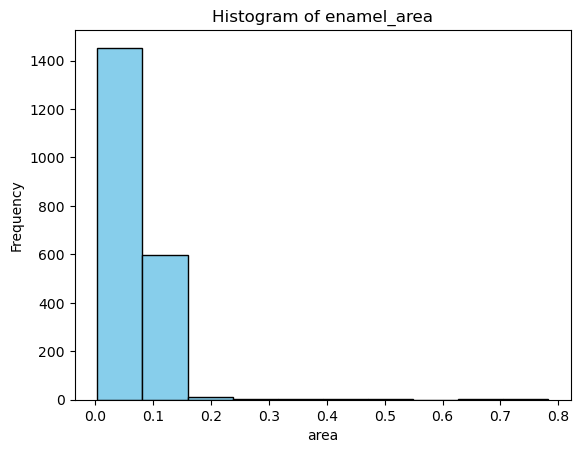

In [10]:
import matplotlib.pyplot as plt
counts,bins,_=plt.hist(enamel_areas, bins=10, density=False, color='skyblue', edgecolor='black')
bin_boundaries = [(bins[i], bins[i+1]) for i in range(len(bins)-1)]

total_points = len(enamel_areas)
bin_percentages = [(count / total_points) * 100 for count in counts]
# Print the bin boundaries and percentages
for i, (lower, upper) in enumerate(zip(bins[:-1], bins[1:])):
    print(f"Bin {i+1}: [{lower}, {upper}] - Percentage: {bin_percentages[i]:.2f}%")
plt.xlabel('area')
plt.ylabel('Frequency')
plt.title('Histogram of enamel_area')
print(bin_boundaries)

Bin 1: [0.0035132416064453122, 0.04246437712623371] - Percentage: 23.59%
Bin 2: [0.04246437712623371, 0.0814155126460221] - Percentage: 46.50%
Bin 3: [0.0814155126460221, 0.1203666481658105] - Percentage: 26.77%
Bin 4: [0.1203666481658105, 0.1593177836855989] - Percentage: 2.03%
Bin 5: [0.1593177836855989, 0.1982689192053873] - Percentage: 0.39%
Bin 6: [0.1982689192053873, 0.23722005472517568] - Percentage: 0.14%
Bin 7: [0.23722005472517568, 0.2761711902449641] - Percentage: 0.05%
Bin 8: [0.2761711902449641, 0.3151223257647525] - Percentage: 0.05%
Bin 9: [0.3151223257647525, 0.3540734612845409] - Percentage: 0.05%
Bin 10: [0.3540734612845409, 0.39302459680432933] - Percentage: 0.00%
Bin 11: [0.39302459680432933, 0.43197573232411773] - Percentage: 0.05%
Bin 12: [0.43197573232411773, 0.4709268678439061] - Percentage: 0.14%
Bin 13: [0.4709268678439061, 0.5098780033636945] - Percentage: 0.05%
Bin 14: [0.5098780033636945, 0.5488291388834828] - Percentage: 0.05%
Bin 15: [0.5488291388834828, 

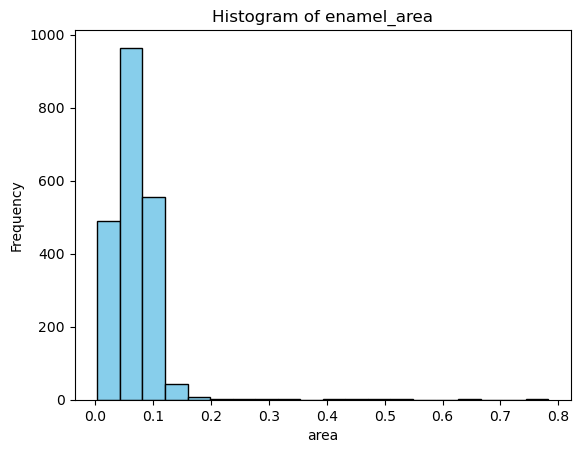

In [12]:
import matplotlib.pyplot as plt
counts,bins,_=plt.hist(enamel_areas, bins=20, density=False, color='skyblue', edgecolor='black')
bin_boundaries = [(bins[i], bins[i+1]) for i in range(len(bins)-1)]

total_points = len(enamel_areas)
bin_percentages = [(count / total_points) * 100 for count in counts]
# Print the bin boundaries and percentages
for i, (lower, upper) in enumerate(zip(bins[:-1], bins[1:])):
    print(f"Bin {i+1}: [{lower}, {upper}] - Percentage: {bin_percentages[i]:.2f}%")
plt.xlabel('area')
plt.ylabel('Frequency')
plt.title('Histogram of enamel_area')
print(bin_boundaries)

Bin 1: [0.0035132416064453122, 0.1593177836855989] - Percentage: 98.89%
Bin 2: [0.1593177836855989, 0.3151223257647525] - Percentage: 0.63%
Bin 3: [0.3151223257647525, 0.4709268678439061] - Percentage: 0.24%
Bin 4: [0.4709268678439061, 0.6267314099230596] - Percentage: 0.10%
Bin 5: [0.6267314099230596, 0.7825359520022133] - Percentage: 0.14%
[(0.0035132416064453122, 0.1593177836855989), (0.1593177836855989, 0.3151223257647525), (0.3151223257647525, 0.4709268678439061), (0.4709268678439061, 0.6267314099230596), (0.6267314099230596, 0.7825359520022133)]


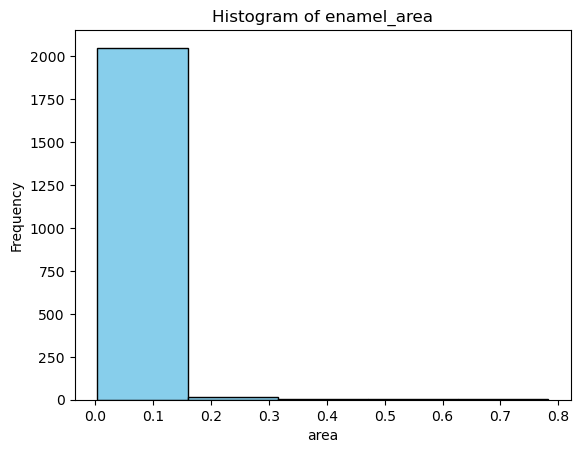

In [13]:
import matplotlib.pyplot as plt
counts,bins,_=plt.hist(enamel_areas, bins=5, density=False, color='skyblue', edgecolor='black')
bin_boundaries = [(bins[i], bins[i+1]) for i in range(len(bins)-1)]

total_points = len(enamel_areas)
bin_percentages = [(count / total_points) * 100 for count in counts]
# Print the bin boundaries and percentages
for i, (lower, upper) in enumerate(zip(bins[:-1], bins[1:])):
    print(f"Bin {i+1}: [{lower}, {upper}] - Percentage: {bin_percentages[i]:.2f}%")
plt.xlabel('area')
plt.ylabel('Frequency')
plt.title('Histogram of enamel_area')
print(bin_boundaries)

Bin 1: [0.021484375, 0.4717770875] - Percentage: 98.84%
Bin 2: [0.4717770875, 0.9220698] - Percentage: 0.96%
Bin 3: [0.9220698, 1.3723625125] - Percentage: 0.14%
Bin 4: [1.3723625125, 1.822655225] - Percentage: 0.00%
Bin 5: [1.822655225, 2.2729479375] - Percentage: 0.05%
[(0.021484375, 0.4717770875), (0.4717770875, 0.9220698), (0.9220698, 1.3723625125), (1.3723625125, 1.822655225), (1.822655225, 2.2729479375)]


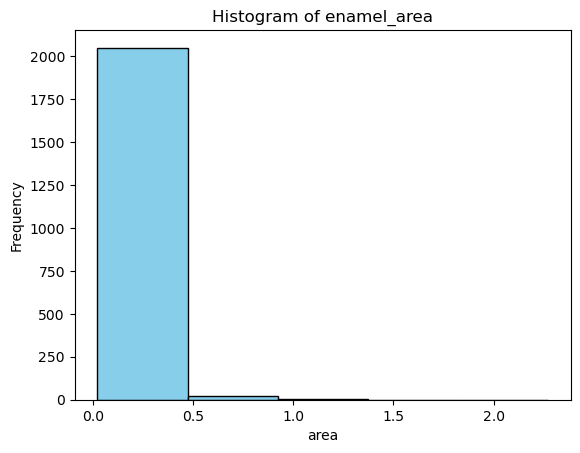

In [31]:
import matplotlib.pyplot as plt
counts,bins,_=plt.hist(enamel_width, bins=5, density=False, color='skyblue', edgecolor='black')
bin_boundaries = [(bins[i], bins[i+1]) for i in range(len(bins)-1)]

total_points = len(enamel_areas)
bin_percentages = [(count / total_points) * 100 for count in counts]
# Print the bin boundaries and percentages
for i, (lower, upper) in enumerate(zip(bins[:-1], bins[1:])):
    print(f"Bin {i+1}: [{lower}, {upper}] - Percentage: {bin_percentages[i]:.2f}%")
plt.xlabel('area')
plt.ylabel('Frequency')
plt.title('Histogram of enamel_area')
print(bin_boundaries)

## introducing thresholding by using area

In [14]:
import os

def process_files_in_directory(directory, threshold):
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            filepath = os.path.join(directory, filename)
            process_file(filepath, threshold)

def process_file(filepath, threshold):
    lines_to_keep = []

    with open(filepath, 'r') as file:
        lines = file.readlines()

    for line in lines:
        values = line.split()
        class_id = int(values[0])
        width = float(values[3])
        height = float(values[4])
        area = width * height

        if class_id == 1 and area <= threshold:
            lines_to_keep.append(line)
        elif class_id == 0:
            lines_to_keep.append(line)

    with open(filepath, 'w') as file:
        file.writelines(lines_to_keep)


# Example usage
directory =r"C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\data filtering\area_0.1593177836855989"
threshold = 0.1593177836855989
process_files_in_directory(directory, threshold)

## thresholding with area and with width

In [12]:
import os

def process_files_in_directory(directory, threshold_area, threshold_width):
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            filepath = os.path.join(directory, filename)
            process_file(filepath, threshold_area,threshold_width)

def process_file(filepath, threshold_area,threshold_width):
    lines_to_keep = []

    with open(filepath, 'r') as file:
        lines = file.readlines()

    for line in lines:
        values = line.split()
        class_id = int(values[0])
        width = float(values[3])
        height = float(values[4])
        area = width * height

        if class_id == 1 and area <= threshold_area and width<=threshold_width:
            lines_to_keep.append(line)
        elif class_id == 0:
            lines_to_keep.append(line)

    with open(filepath, 'w') as file:
        file.writelines(lines_to_keep)


# Example usage
directory =r"C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\final\unionized"
threshold_area = 0.1593177836855989
threshold_width=0.4717770875
process_files_in_directory(directory, threshold_area,threshold_width)

## move background images

In [2]:
import os
import random
import shutil

# Define the source image directory
source_image_directory = r"C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\combined (2)\images"

# Define the source text directory
source_text_directory = r"C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\combined (2)\unionized"

# Define the destination directory for images without corresponding text files
destination_directory = r"C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\raw-data\combined (2)\background"

# Create destination directory if it doesn't exist
os.makedirs(destination_directory, exist_ok=True)

# Get a list of image files in the source image directory
image_files = [f for f in os.listdir(source_image_directory) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Filter out images that have corresponding text files
image_files_no_text = [image_file for image_file in image_files if not os.path.exists(os.path.join(source_text_directory, os.path.splitext(image_file)[0] + '.txt'))]

# Randomly select 173 image files without corresponding text files
random_images_no_text = random.sample(image_files_no_text, min(26, len(image_files_no_text)))

# Move the selected images to the destination directory
for image_file in random_images_no_text:
    shutil.move(os.path.join(source_image_directory, image_file), os.path.join(destination_directory, image_file))
    print(f"Moved {image_file} to destination directory")

Moved 317_jpg_2023100518452221.jpg to destination directory
Moved 323_jpg_2023100518452232.jpg to destination directory
Moved 322_jpg_2023100518452230.jpg to destination directory
Moved 443w_jpg_20231005184522266.jpg to destination directory
Moved 441w_jpg_20231005184522263.jpg to destination directory
Moved 316_jpg_2023100518452219.jpg to destination directory
Moved 402w_jpg_20231005184522178.jpg to destination directory
Moved 312_jpg_2023100518452213.jpg to destination directory
Moved 330_jpg_2023100518452243.jpg to destination directory
Moved 325_jpg_2023100518452233.jpg to destination directory
Moved 338_jpg_2023100518452258.jpg to destination directory
Moved 314_jpg_2023100518452216.jpg to destination directory
Moved 311_jpg_2023100518452212.jpg to destination directory
Moved 320_jpg_2023100518452227.jpg to destination directory
Moved 436w_jpg_20231005184522255.jpg to destination directory
Moved 313_jpg_2023100518452215.jpg to destination directory
Moved 328_jpg_2023100518452240.j

In [6]:

import os







def parse_annotation_line(line):
    parts = line.strip().split()
    class_id = parts[0]
    bbox = list(map(float, parts[1:5]))
    landmarks = " ".join(parts[5:])
    return class_id, bbox, landmarks

def parse_directory(directory):
    annotations = {}
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            with open(os.path.join(directory, filename), "r") as file:
                lines = file.readlines()
                annotations[filename] = [parse_annotation_line(line) for line in lines]
    return annotations

def calculate_union_bbox(bbox_A, bbox_B):
    x1 = min(bbox_A[0] - bbox_A[2]/2, bbox_B[0] - bbox_B[2]/2)
    y1 = min(bbox_A[1] - bbox_A[3]/2, bbox_B[1] - bbox_B[3]/2)
    x2 = max(bbox_A[0] + bbox_A[2]/2, bbox_B[0] + bbox_B[2]/2)
    y2 = max(bbox_A[1] + bbox_A[3]/2, bbox_B[1] + bbox_B[3]/2)
    width = x2 - x1
    height = y2 - y1
    return [x1 + width/2, y1 + height/2, width, height]

def write_union_annotations(annotations_A, annotations_B, output_directory):
    for filename, annotations_list_A in annotations_A.items():
        annotations_list_B = annotations_B.get(filename, [])
        print(f"Processing file: {filename}")
        with open(os.path.join(output_directory, filename), "w") as output_file:
            for annotation_A in annotations_list_A:
                for annotation_B in annotations_list_B:
                    if annotation_A[0][:3] == annotation_B[0][:3] and annotation_A[2][:3] ==annotation_B[2][:3]:
                        class_id = annotation_A[0]
                        bbox_A = annotation_A[1]
                        bbox_B = annotation_B[1]
                        union_bbox = calculate_union_bbox(bbox_A, bbox_B)
                        landmarks = annotation_A[2]
                        output_line = f"{class_id} {' '.join(map(str, union_bbox))} {landmarks}\n"
                        print("Union annotation:", output_line)
                        output_file.write(output_line)
                        break  # Exit the loop after finding a matching annotation pair

directory_A =r"C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\data filtering\preprocessed_data\l1"
directory_B =r"C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\data filtering\common\skeleton\labels"
output_directory =r"C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\data filtering\rounded_unionized"


annotations_A = parse_directory(directory_A)
annotations_B = parse_directory(directory_B)

write_union_annotations(annotations_A, annotations_B, output_directory)

Processing file: 1._jpg_20231005184521369.txt
Union annotation: 0 0.04790527343749999 0.036020507812500005 0.03196289062499999 0.07399414062500001 0.031923828125 0.073017578125 2 0.06388671875 0.070732421875 2

Union annotation: 0 0.25341796875 0.050693359375 0.0556640625 0.09943359375 0.225986328125 0.10041015625 2 0.25794921875 0.091279296875 2

Union annotation: 0 0.224609375 0.96728515625 0.126953125 0.0634765625 0.174208984375 0.938154296875 2 0.275009765625 0.9678515625 2

Union annotation: 1 0.39653808593749995 0.76611328125 0.3575292968749999 0.3798828125 0.2762109375 0.945166015625 2 0.575302734375 0.831005859375 2

Union annotation: 1 0.1201171875 0.73828125 0.208984375 0.27734375 0.02279296875 0.8469921875 2 0.1734765625 0.872099609375 2

Union annotation: 1 0.08722656250000001 0.48780761718750004 0.17250000000000001 0.7685839843750001 0.02279296875 0.107265625 2 0.029638671875 0.03419921875 1

Union annotation: 1 0.39800292968749995 0.5306884765625001 0.3545996093749999 0.8

Processing file: 604w_jpg_20231005184520628.txt
Union annotation: 1 0.16313964843749998 0.6775390625 0.30704101562499997 0.27666015624999996 0.04046875 0.815869140625 2 0.31666015625 0.739677734375 2

Union annotation: 1 0.49126953125 0.6318408203125 0.3013671875 0.2537597656249999 0.3626953125 0.758720703125 2 0.635703125 0.723798828125 2

Union annotation: 1 0.7966796875 0.59822265625 0.31931640625 0.25117187500000004 0.683330078125 0.72380859375 2 0.956337890625 0.674599609375 2

Union annotation: 1 0.5278955078125 0.0547607421875 0.25104492187500005 0.109521484375 0.402373046875 0.10634765625 2 0.615068359375 0.109521484375 2

Union annotation: 1 0.27095214843750004 0.0709619140625 0.276845703125 0.13743164062500002 0.132529296875 0.092060546875 2 0.370625 0.139677734375 2

Union annotation: 1 0.178564453125 0.40793457031249997 0.27619140625 0.8158691406249999 0.00396484375 0.139677734375 1 0.0626953125 0.13173828125 2

Union annotation: 1 0.7991455078125 0.37740234375000004 0.3143

## train test val split

In [3]:
import os
import random
import shutil

# Define the source image directory
source_image_directory = r"C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\combined\final\train\images"

# Define the source text directory
source_text_directory = r"C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\combined\final\train\labels"

# Define the destination image directory
destination_image_directory = r"C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\combined\final\val\images"

# Define the destination text directory
destination_text_directory = r"C:\Users\HP\Desktop\dental\DentalPanoramicXrays\landmark_detection\preprocessing\combined\final\val\labels"

# Create destination directories if they don't exist
os.makedirs(destination_image_directory, exist_ok=True)
os.makedirs(destination_text_directory, exist_ok=True)

# Get a list of text files in the source text directory
text_files = [f for f in os.listdir(source_text_directory) if f.endswith('.txt')]

# Randomly select 293 text files
random_texts = random.sample(text_files, 63)

# Move the selected text files and their corresponding image files
for text_file in random_texts:
    base_name = os.path.splitext(text_file)[0]
    # Look for image file with various extensions
    possible_extensions = ['.jpg', '.jpeg', '.png']
    image_file = None
    for ext in possible_extensions:
        if os.path.exists(os.path.join(source_image_directory, base_name + ext)):
            image_file = base_name + ext
            break
    
    if image_file:
        # Move the text file to the destination text directory
        shutil.move(os.path.join(source_text_directory, text_file), os.path.join(destination_text_directory, text_file))

        # Move the image file to the destination image directory
        shutil.move(os.path.join(source_image_directory, image_file), os.path.join(destination_image_directory, image_file))

        print(f"Moved {text_file} and {image_file} to destination directories")
    else:
        print(f"Skipping {text_file} because the corresponding image file does not exist")

# Note: You may want to adjust the paths and filenames as needed for your specific directory structure and file names.